# Telecom churn prediction
---

In this notebook, I want to show how to preprocess telecom data and build new features. For prediction, I've used the **Catboost model**, which is an algorithm for gradient boosting on decision trees. CatBoost is a very fast performer and can work with categorical features without encoding, so it'll save us time. For explaining the model I've used **SHAP library** which gives clear interpretability of predictions and also helps to get some useful insights. So, let's start!

* [PREPROCESSING](#PREPROCESSING)
    * [1. Constant features removing](#sub_1)
    * [2. Duplicated features removing](#sub_2)
    * [3. Date features](#sub_3)
* [FEATURE ENGINEERING](#FE)
    * [1. Roaming](#1)
    * [5. T2T loc](#2)
    * [3. T2T std](#3)
    * [4. T2M LOC](#4)
    * [5. T2M STD](#5)
    * [6. T2F LOC](#6)
    * [7. T2F STD](#7)
    * [8. T2C](#8)
    * [9. ARPU](#9)
    * [10. ONNET](#10)
    * [11. OFFNET](#11)
    * [12. ISD](#12)
    * [13. SPL](#13)
    * [14. TOTAL OG\IC](#14)
    * [15. LOC OG\IC](#15)
    * [16. STD OG\IC](#16)
    * [17. OTHERS](#17)
    * [18. RECH AMT](#18)
    * [19. RECH NUM](#19)
    * [20. RECH DATA TOTAL](#20)
    * [21. LAST DAY REACH AMT](#21)
    * [22. RECH 2G AND 3G](#22)
    * [23. VOL 2G&3G](#23)
    * [24. ARPU 2G&3G](#24)
    * [25. VBC](#25)
    * [26. MONTHLY](#26)
    * [27. MAX RECH](#27)
    * [28. SACHET](#28)
    * [29. NIGHT PCK](#29)
    * [30. AON](#30)
    * [31. USELESS FEATURES](#31)
    * [32. CAT FEATURES](#32)
* [TEST DATA PREPROCESSING](#test_data_preproc)
* [FEATURE SELECTION](#FS)
* [CatBoost + OPTUNA](#catboost_optuna)
* [SHAP Values](#shap)
* [INSIGHTS](#insights)

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.options.mode.chained_assignment = None  # default='warn'

from datetime import date
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

####################################################
### CATBOOST + OPTUNA + SHAP
####################################################

from catboost import CatBoostClassifier, Pool
from optuna.integration import CatBoostPruningCallback
from catboost import Pool, cv
import catboost
import optuna
import shap

### LOAD DATA

In [3]:
df = pd.read_csv('data/train.csv')
print(df.shape)

df_test = pd.read_csv('data/test.csv')
print(df_test.shape)

(69999, 172)

(30000, 171)


In [4]:
### Check target
df.churn_probability.value_counts() / len(df)

0    0.898113
1    0.101887
Name: churn_probability, dtype: float64

It's an **imbalanced dataset**.

## PREPROCESSING <a class="anchor"  id="PREPROCESSING"></a>

### 1. Constant features removing <a class="anchor"  id="sub_1"></a>

In [5]:
constant_features = [feat for feat in df.columns if df[feat].nunique() == 1]
len(constant_features)

13

We have 13 constant features and they ate totally useless, so I'll remove them. It could be a mistake in the ETL process or this subsample was chosen with specific criteria.

In [6]:
df.drop(constant_features, axis=1, inplace=True)

### 2. Duplicated features removing<a class="anchor"  id="sub_2"></a>

In [7]:
# an empty dictionary for storing the groups of duplicates
duplicated_feat_pairs = {}

# an empty list to collect features that were found to be duplicated
columns_dupl = []

# iterate over every feature in our dataset:
for i in range(0, len(df.columns)):    
    # choose 1 feature:
    feat_1 = df.columns[i]
    
    # check if this feature has already been identified as a duplicate of another one.
    # If it was, it should be stored in our columns_dupl list.
    # If this feature was already identified as a duplicate, we skip it, if
    # it has not yet been identified as a duplicate, then we proceed:
    if feat_1 not in columns_dupl:
        duplicated_feat_pairs[feat_1] = []
        # now, iterate over the remaining features of the dataset:
        for feat_2 in df.columns[i + 1:]:
            # check if this second feature is identical to the first one
            if df[feat_1].equals(df[feat_2]):
                # if it is identical, append it to the list in the dictionary
                duplicated_feat_pairs[feat_1].append(feat_2)               
                # and append it to our monitor list for duplicated variables
                columns_dupl.append(feat_2)

In [8]:
len(columns_dupl)

0

In [9]:
### Let's check what features are duplicated
{key: val for key, val in duplicated_feat_pairs.items() if val}

{}

Note: There are no duplicate features, but it is because we have already deleted const columns. I want to save this part and show how we can find them :)

### 3. Date features<a class="anchor"  id="sub_3"></a>

It could be important to know how many days have passed from last recharge. Let's create this features.

In [10]:
object_cols = df.columns[df.dtypes == 'object'].to_list()
print(object_cols)

['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8']


In [11]:
date_of_last_rech = ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']
date_of_last_rech_data = ['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8']

For churn prediction, it's important to score data as fast as it's possible, so I choose a date in September 2014, when theoretically all data could be collected.

In [12]:
own_date = date(2014, 9, 10)

In [13]:
# convert date_cols to datetime
# select max() date in date_cols and compute the diff with 'today' in days
# drop date_cols, add a new column with 'new_col_name' with a count of days
# df[date_cols].apply(pd.to_datetime)

def day_counts(df, date_cols, today, new_col_name):   
    df[new_col_name] = (pd.Timestamp(own_date) - df[date_cols].apply(pd.to_datetime).max(axis=1)).dt.days 
    df.drop(date_cols, axis=1, inplace=True)

In [14]:
day_counts(df, date_of_last_rech, own_date, 'last_rech_days')
day_counts(df, date_of_last_rech_data, own_date, 'last_rech_data_days')

In [15]:
df[['last_rech_days', 'last_rech_data_days']].isnull().mean()

last_rech_days         0.000929
last_rech_data_days    0.626809
dtype: float64

In [16]:
df[['last_rech_days', 'last_rech_data_days']] = df[['last_rech_days', 'last_rech_data_days']].fillna(-1)

Text(0.5, 1.0, 'Days from last reach (DATA)')

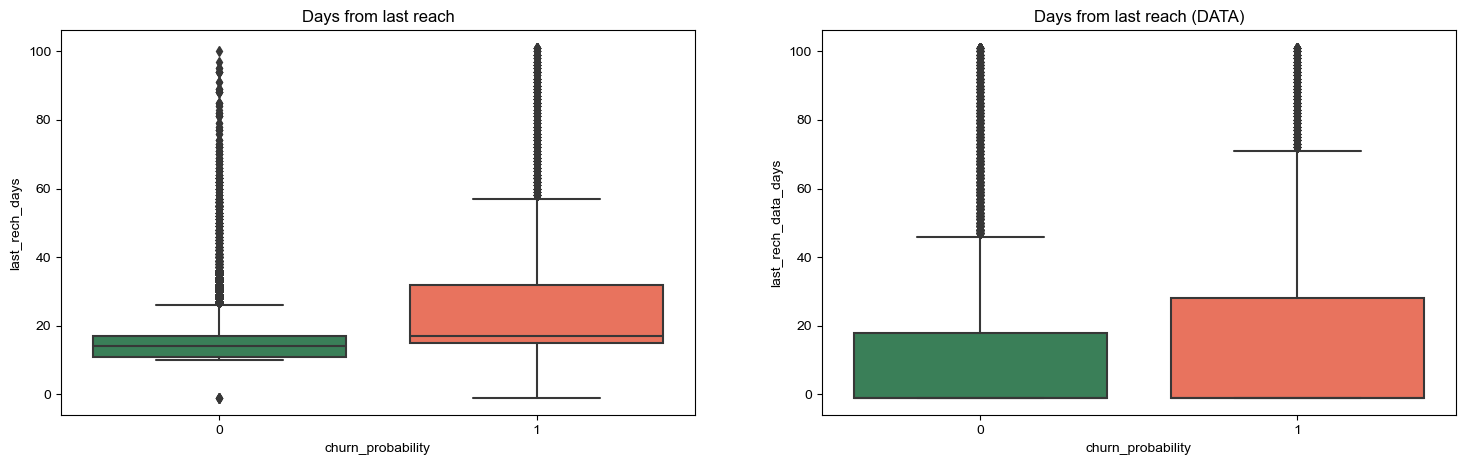

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='last_rech_days', palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='last_rech_data_days', palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])
axes[0].set_title('Days from last reach')
axes[1].set_title('Days from last reach (DATA)')

## USEFUL FUNCTIONS FOR FEATURE ENGINEERING <a class="anchor"  id="FE"></a>

I divided the features into logical groups and worked with each group separately. My idea was to create new features based on all 3 months because it's essential to work with trends. For example, a count of calls for the previous month doesn't say anything special about the customer, but a ratio of calls for the previous 3 months can show, that customer started using his mobile phone less than before and it could be an indicator that he (or she) had already bought a competitors' SIM card. 

For each logical group, I checked the mean, and median and created a ratio:  
*Ratio = feature_8m / mean(feature_7m + feature_6m)*  
Mean and median are hight correlated and we can use only one of them for the model, but in this part, I wanted to save them for charts, so I would drop them in the Feature selection section.  
In all charts, I cut off the outliers by using the parameter showfliers, it gives us a better visualization and we can find some interesting business insights which we'll discuss in the **Conclusion section**.  
So, let's go, this part will be quite tedious and long.

In [18]:
def ratio_column(df, column_name, numerator, denominator, fill_inf_val):
    df[column_name] = df[numerator].sum(axis=1)/df[denominator].mean(axis=1)
    df[column_name] = df[column_name].fillna(0)
    df[column_name].replace([np.inf, -np.inf], fill_inf_val, inplace=True)

### 1. Roaming <a class="anchor"  id="1"></a>

In [19]:
### list of features that have been already preprocessed
preproc_cols = []

In [20]:
col_roam = df.columns[df.columns.str.contains('roam')]

In [21]:
df[col_roam].isnull().mean()

roam_ic_mou_6    0.039543
roam_ic_mou_7    0.038386
roam_ic_mou_8    0.052901
roam_og_mou_6    0.039543
roam_og_mou_7    0.038386
roam_og_mou_8    0.052901
dtype: float64

I think that the physical meaning of null here is that customer didn't use SIM or it was blocked or something like this. I'll fill it with 0.

In [22]:
df[col_roam] = df[col_roam].fillna(0)

In [23]:
df.groupby('churn_probability')[col_roam].mean()

,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8
churn_probability,,,,,,
0,8.627277,5.749921,5.744561,12.381374,8.148038,8.016592
1,16.007982,15.519393,14.477426,24.591959,21.067705,20.169801


So, We can say that people travel more in June :) Let's invent new metrics. My ideas here: 
1) I'm not sure, that we should separate In\Out calls here because it's more important to indicate that a customer use roaming. So, we can use the group mean.  
2) It could be important to indicate a change in behavior. If a customer moved somewhere during the previous month he may be would change his operator for local. I want to find a ratio between August and the previous two months.

In [24]:
df['mean_roam'] = df[col_roam].mean(axis=1)

In [25]:
df['ratio_roam'] = df[['roam_ic_mou_8', 'roam_og_mou_8']].sum(axis=1) /\
df[['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_og_mou_6', 'roam_og_mou_7']].mean(axis=1)

In [26]:
df.ratio_roam.describe()

count    2.298900e+04
mean              inf
std               NaN
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.618609e+00
max               inf
Name: ratio_roam, dtype: float64

Here we have Nan (when the numerator and denominator are 0) and inf (when the numerator > 0). NaN values I'll replace with 0 and inf with 32000 because it's bigger then max ratio value.

In [27]:
df['ratio_roam'] = df['ratio_roam'].fillna(0)
df['ratio_roam'].replace([np.inf, -np.inf], 32000, inplace=True)

In [28]:
df['ratio_roam'].describe()

count    69999.000000
mean      1597.813775
std       6965.699724
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      32000.000000
Name: ratio_roam, dtype: float64

In [29]:
df.groupby('churn_probability')[col_roam].mean()

,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8
churn_probability,,,,,,
0,8.627277,5.749921,5.744561,12.381374,8.148038,8.016592
1,16.007982,15.519393,14.477426,24.591959,21.067705,20.169801


Text(0.5, 1.0, 'Ratio of roaming')

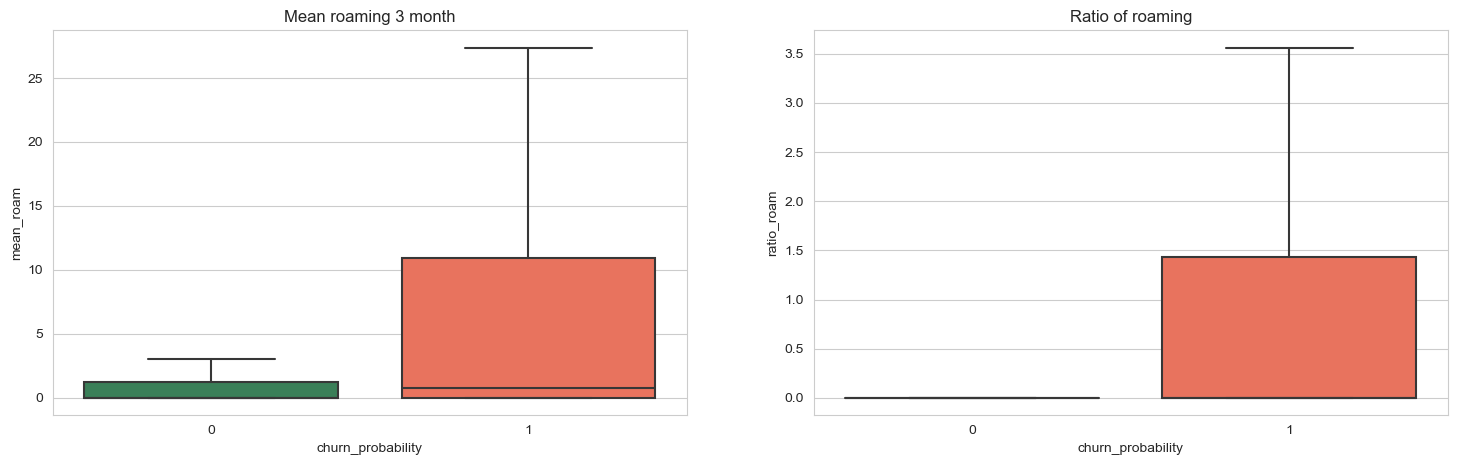

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='mean_roam', showfliers=False, 
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='ratio_roam', showfliers=False, 
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])

axes[0].set_title('Mean roaming 3 month')
axes[1].set_title('Ratio of roaming')

In [31]:
preproc_cols.extend(col_roam.to_list())
len(preproc_cols)

6

### 2. T2T loc<a class="anchor"  id="2"></a>

In [32]:
df.columns[df.columns.str.contains('t2t')]

Index(['loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8',
       'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8',
       'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8'],
      dtype='object')

In [33]:
loc_t2t = ['loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
           'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8']

In [34]:
df[loc_t2t].isna().mean()

loc_og_t2t_mou_6    0.039543
loc_og_t2t_mou_7    0.038386
loc_og_t2t_mou_8    0.052901
loc_ic_t2t_mou_6    0.039543
loc_ic_t2t_mou_7    0.038386
loc_ic_t2t_mou_8    0.052901
dtype: float64

In [35]:
df[loc_t2t] = df[loc_t2t].fillna(0)

In [36]:
df.groupby('churn_probability')[loc_t2t].mean()

,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8
churn_probability,,,,,,
0,47.054445,47.447590,47.365118,47.932379,48.794878,48.966170
1,27.382006,17.480652,7.165370,30.374544,21.802458,7.649083


In [37]:
df.groupby('churn_probability')[loc_t2t].median()

,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8
churn_probability,,,,,,
0,11.760,12.09,12.68,15.76,16.53,17.23
1,3.185,0.26,0.00,4.16,0.63,0.00


So, I'm going to add mean, and median values to dataset and ratio

In [38]:
df['mean_loc_t2t'] = df[loc_t2t].mean(axis=1)
df['median_loc_t2t'] = df[loc_t2t].median(axis=1)

In [39]:
ratio_column(df, 'ratio_loc_t2t', ['loc_og_t2t_mou_8', 'loc_ic_t2t_mou_8'], 
             ['loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7'], 30000)

Text(0.5, 1.0, 'RATIO loc_t2t')

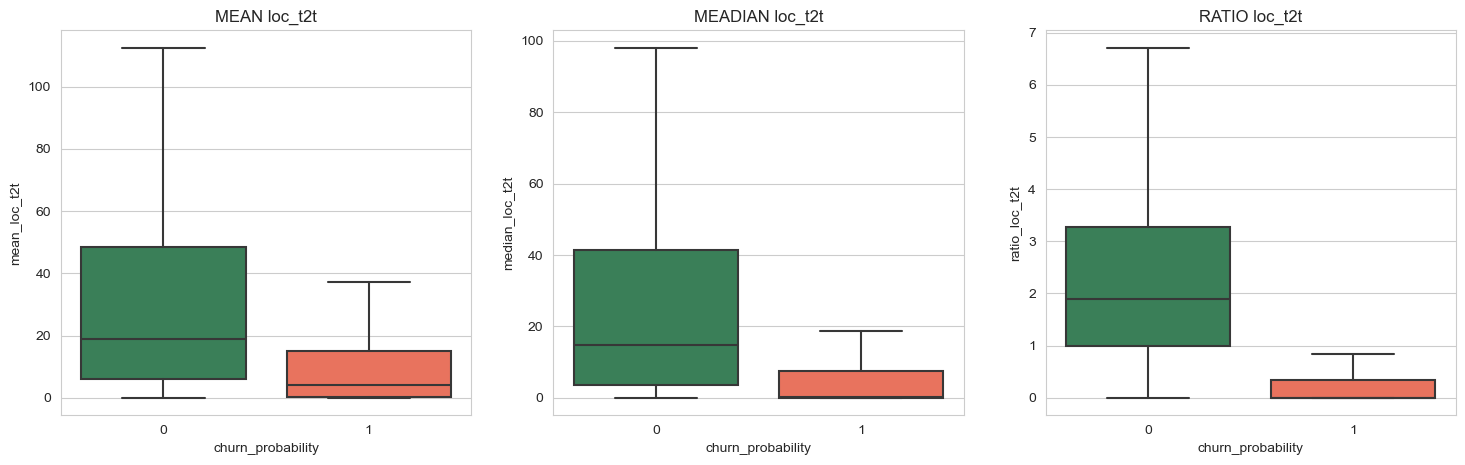

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='mean_loc_t2t', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='median_loc_t2t', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])
sns.boxplot(data=df, x='churn_probability', y='ratio_loc_t2t', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[2])

axes[0].set_title('MEAN loc_t2t')
axes[1].set_title('MEADIAN loc_t2t')
axes[2].set_title('RATIO loc_t2t')

In [41]:
preproc_cols.extend(loc_t2t)
len(preproc_cols)

12

### 3. T2T std <a class="anchor"  id="3"></a>

In [42]:
std_t2t = ['std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8',
           'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8']

In [43]:
df[std_t2t].isna().mean()

std_og_t2t_mou_6    0.039543
std_og_t2t_mou_7    0.038386
std_og_t2t_mou_8    0.052901
std_ic_t2t_mou_6    0.039543
std_ic_t2t_mou_7    0.038386
std_ic_t2t_mou_8    0.052901
dtype: float64

In [44]:
df[std_t2t] = df[std_t2t].fillna(0)

In [45]:
df.groupby('churn_probability')[std_t2t].mean()

,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8
churn_probability,,,,,,
0,71.573893,79.557237,84.188714,8.917608,9.657046,10.117386
1,129.064177,89.399222,33.810116,10.729403,8.061321,2.938589


In [46]:
df.groupby('churn_probability')[std_t2t].median()

,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8
churn_probability,,,,,,
0,0.00,0.0,0.0,0.0,0.0,0.0
1,0.96,0.0,0.0,0.0,0.0,0.0


So, I'm going to add mean values to dataset and ratio

In [47]:
df['mean_std_t2t'] = df[std_t2t].mean(axis=1)

In [48]:
ratio_column(df, 'ratio_std_t2t', ['std_og_t2t_mou_8', 'std_ic_t2t_mou_8'], 
             ['std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7'], 10000)

Text(0.5, 1.0, 'RATIO std_t2t')

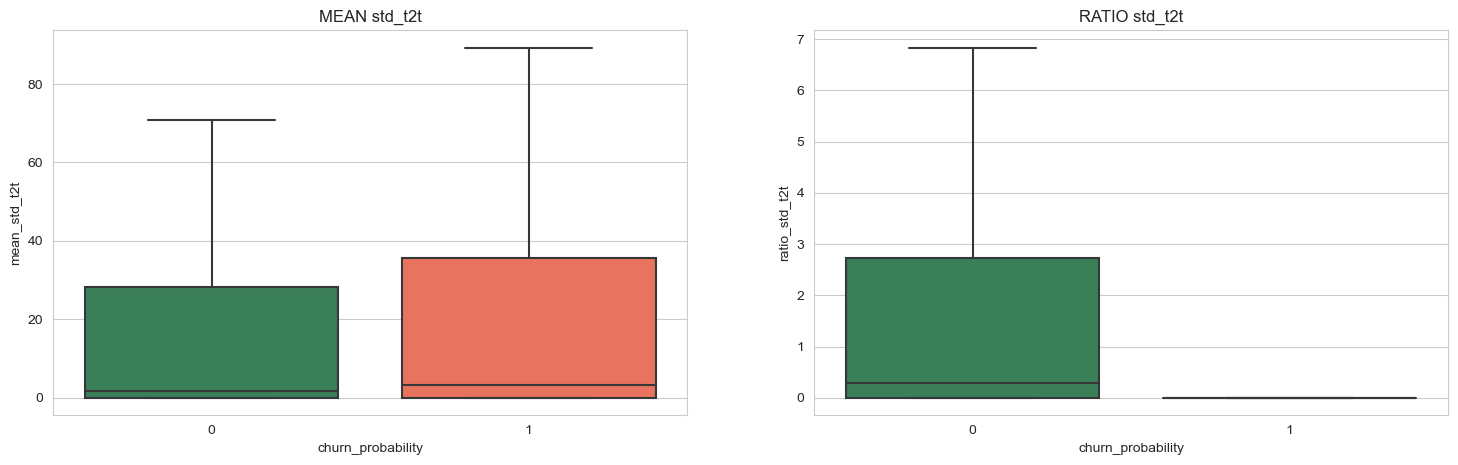

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='mean_std_t2t', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='ratio_std_t2t', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])

axes[0].set_title('MEAN std_t2t')
axes[1].set_title('RATIO std_t2t')

In [50]:
preproc_cols.extend(std_t2t)
len(preproc_cols)

18

### 4. T2M LOC <a class="anchor"  id="4"></a>

In [51]:
df.columns[df.columns.str.contains('t2m')]

Index(['loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8',
       'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8',
       'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8'],
      dtype='object')

In [52]:
loc_t2m = ['loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
           'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8']

In [53]:
df[loc_t2m].isna().mean()

loc_og_t2m_mou_6    0.039543
loc_og_t2m_mou_7    0.038386
loc_og_t2m_mou_8    0.052901
loc_ic_t2m_mou_6    0.039543
loc_ic_t2m_mou_7    0.038386
loc_ic_t2m_mou_8    0.052901
dtype: float64

In [54]:
df[loc_t2m] = df[loc_t2m].fillna(0)

In [55]:
df.groupby('churn_probability')[loc_t2m].mean()

,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8
churn_probability,,,,,,
0,93.636935,93.122553,94.465803,107.541525,109.337261,112.169083
1,53.537061,36.110890,14.330600,62.135808,41.270276,16.614169


In [56]:
df.groupby('churn_probability')[loc_t2m].median()

,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8
churn_probability,,,,,,
0,41.08,41.88,43.13,56.940,59.460,61.79
1,13.44,3.45,0.00,17.985,5.835,0.00


So, I'm going to add mean, and median values to dataset and ratio

In [57]:
df['mean_loc_t2m'] = df[loc_t2m].mean(axis=1)
df['median_loc_t2m'] = df[loc_t2m].median(axis=1)

In [58]:
ratio_column(df, 'ratio_loc_t2m', ['loc_og_t2m_mou_8', 'loc_ic_t2m_mou_8'], 
             ['loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7'], 35000)

Text(0.5, 1.0, 'RATIO loc_t2m')

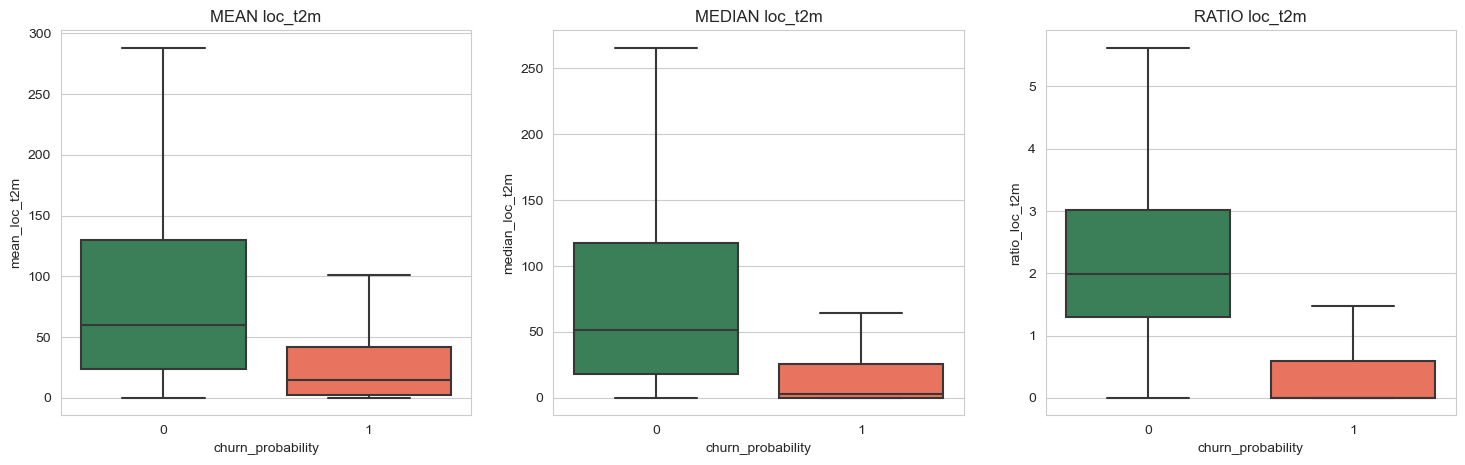

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='mean_loc_t2m', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='median_loc_t2m', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])
sns.boxplot(data=df, x='churn_probability', y='ratio_loc_t2m', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[2])

axes[0].set_title('MEAN loc_t2m')
axes[1].set_title('MEDIAN loc_t2m')
axes[2].set_title('RATIO loc_t2m')

In [60]:
preproc_cols.extend(loc_t2m)
len(preproc_cols)

24

### 5. T2M STD <a class="anchor"  id="5"></a>

In [61]:
df.columns[df.columns.str.contains('t2m')]

Index(['loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8',
       'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8',
       'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8',
       'mean_loc_t2m', 'median_loc_t2m', 'ratio_loc_t2m'],
      dtype='object')

In [62]:
std_t2m = ['std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8',
           'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8']

In [63]:
df[std_t2m].isna().mean()

std_og_t2m_mou_6    0.039543
std_og_t2m_mou_7    0.038386
std_og_t2m_mou_8    0.052901
std_ic_t2m_mou_6    0.039543
std_ic_t2m_mou_7    0.038386
std_ic_t2m_mou_8    0.052901
dtype: float64

In [64]:
df[std_t2m] = df[std_t2m].fillna(0)

In [65]:
df.groupby('churn_probability')[std_t2m].mean()

,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8
churn_probability,,,,,,
0,79.064583,87.463134,91.620660,19.784267,21.647115,21.595021
1,134.043940,92.975660,34.441896,21.066706,13.852450,5.679320


In [66]:
df.groupby('churn_probability')[std_t2m].median()

,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8
churn_probability,,,,,,
0,2.66,3.14,3.51,1.63,1.96,2.19
1,7.53,0.00,0.00,1.17,0.00,0.00


So, I'm going to add mean, and median values to dataset and ratio

In [67]:
df['mean_std_t2m'] = df[std_t2m].mean(axis=1)
df['median_std_t2m'] = df[std_t2m].median(axis=1)

In [68]:
ratio_column(df, 'ratio_std_t2m', ['std_og_t2m_mou_8', 'std_ic_t2m_mou_8'], 
             ['std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7'], 100000)

Text(0.5, 1.0, 'RATIO std_t2m')

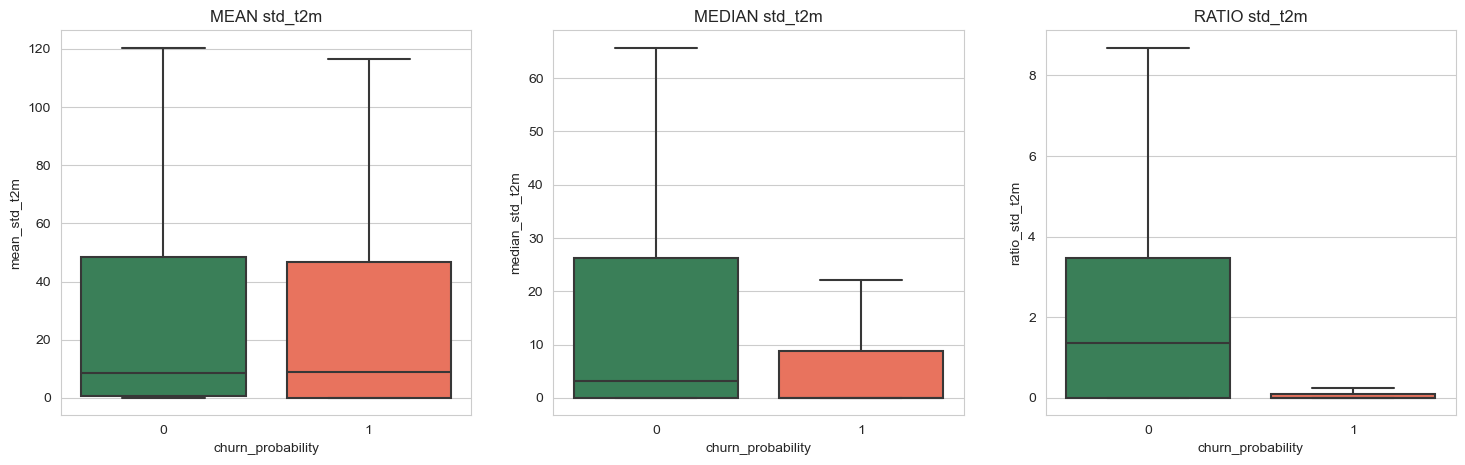

In [69]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='mean_std_t2m', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='median_std_t2m', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])
sns.boxplot(data=df, x='churn_probability', y='ratio_std_t2m', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[2])

axes[0].set_title('MEAN std_t2m')
axes[1].set_title('MEDIAN std_t2m')
axes[2].set_title('RATIO std_t2m')

In [70]:
preproc_cols.extend(std_t2m)
len(preproc_cols)

30

### 6. T2F LOC <a class="anchor"  id="6"></a>

In [71]:
df.columns[df.columns.str.contains('t2f')]

Index(['loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8',
       'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8',
       'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8'],
      dtype='object')

In [72]:
loc_t2f = ['loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
           'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8']

In [73]:
df[loc_t2f].isna().mean()

loc_og_t2f_mou_6    0.039543
loc_og_t2f_mou_7    0.038386
loc_og_t2f_mou_8    0.052901
loc_ic_t2f_mou_6    0.039543
loc_ic_t2f_mou_7    0.038386
loc_ic_t2f_mou_8    0.052901
dtype: float64

In [74]:
df[loc_t2f] = df[loc_t2f].fillna(0)

In [75]:
df.groupby('churn_probability')[loc_t2f].mean()

,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8
churn_probability,,,,,,
0,3.814690,3.897531,3.786867,12.297887,13.036495,12.20530
1,1.660059,1.291847,0.656748,5.194547,3.662371,1.32697


In [76]:
df.groupby('churn_probability')[loc_t2f].median()

,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8
churn_probability,,,,,,
0,0.0,0.0,0.0,0.93,1.05,1.1
1,0.0,0.0,0.0,0.00,0.00,0.0


So, I'm going to add mean values to dataset and ratio

In [77]:
df['mean_loc_t2f'] = df[loc_t2f].mean(axis=1)
#df['median_std_t2m'] = df[std_t2m].median(axis=1)

In [78]:
ratio_column(df, 'ratio_loc_t2f', ['loc_og_t2f_mou_8', 'loc_ic_t2f_mou_8'], 
             ['loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7'], 8000)


Text(0.5, 1.0, 'RATIO std_t2m')

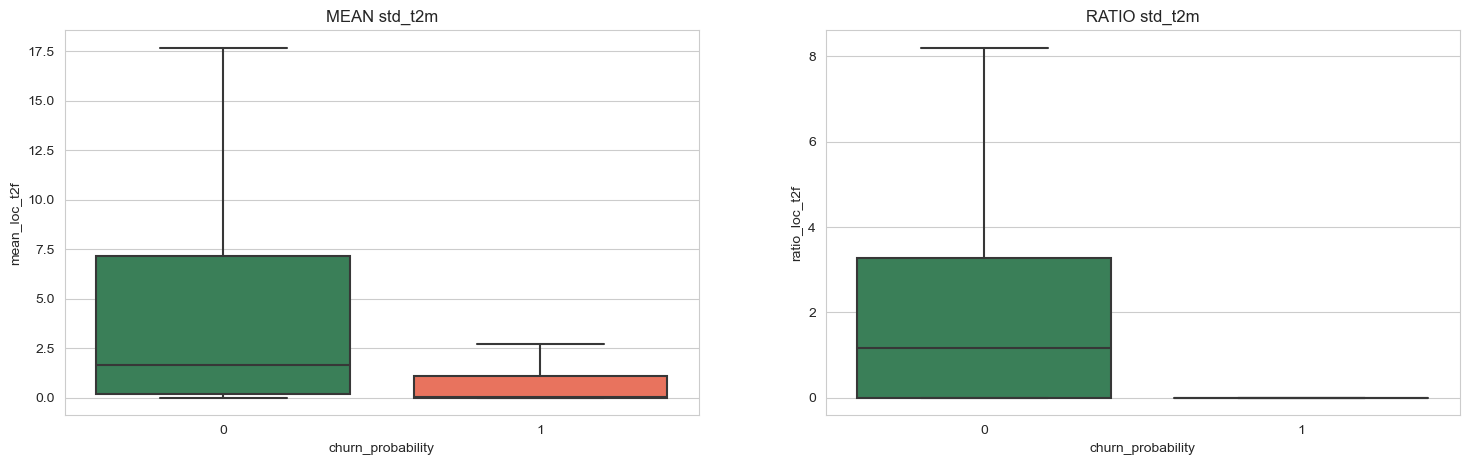

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='mean_loc_t2f', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='ratio_loc_t2f', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])

axes[0].set_title('MEAN std_t2m')
axes[1].set_title('RATIO std_t2m')

In [80]:
preproc_cols.extend(loc_t2f)
len(preproc_cols)

36

### 7. T2F STD <a class="anchor"  id="7"></a>

In [81]:
df.columns[df.columns.str.contains('t2f')]

Index(['loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8',
       'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8',
       'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8',
       'mean_loc_t2f', 'ratio_loc_t2f'],
      dtype='object')

In [82]:
std_t2f = ['std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8',
           'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8']

In [83]:
df[std_t2f].isna().mean()

std_og_t2f_mou_6    0.039543
std_og_t2f_mou_7    0.038386
std_og_t2f_mou_8    0.052901
std_ic_t2f_mou_6    0.039543
std_ic_t2f_mou_7    0.038386
std_ic_t2f_mou_8    0.052901
dtype: float64

In [84]:
df[std_t2f] = df[std_t2f].fillna(0)

In [85]:
df.groupby('churn_probability')[std_t2f].mean()

,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8
churn_probability,,,,,,
0,1.139418,1.105390,1.095358,2.173272,2.275224,2.161635
1,0.574268,0.487637,0.176948,1.075285,0.702346,0.235645


In [86]:
df.groupby('churn_probability')[std_t2f].median()

,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8
churn_probability,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0


So, I'm going to add mean values to dataset and ratio

In [87]:
df['mean_std_t2f'] = df[std_t2f].mean(axis=1)
#df['median_std_t2m'] = df[std_t2m].median(axis=1)

In [88]:
ratio_column(df, 'ratio_std_t2f', ['std_og_t2f_mou_8', 'std_ic_t2f_mou_8'], 
             ['std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7'], 5500)

Text(0.5, 1.0, 'RATIO std_t2f')

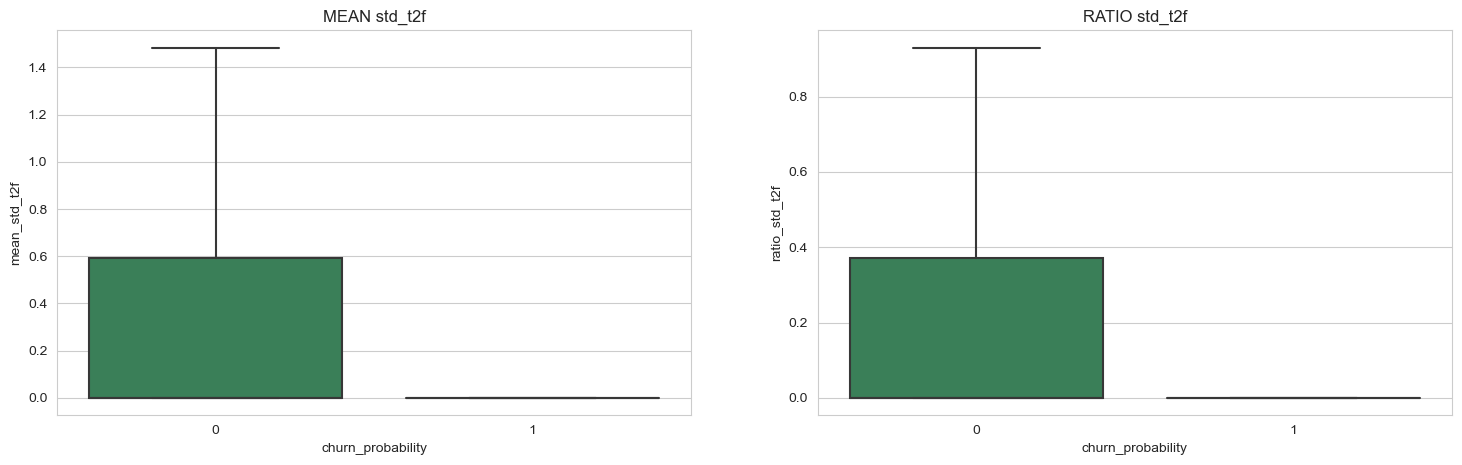

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='mean_std_t2f', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='ratio_std_t2f', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])

axes[0].set_title('MEAN std_t2f')
axes[1].set_title('RATIO std_t2f')

In [90]:
preproc_cols.extend(std_t2f)
len(preproc_cols)

42

### 8. T2C <a class="anchor"  id="8"></a>

In [91]:
df.columns[df.columns.str.contains('t2c')]

Index(['loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8'], dtype='object')

In [92]:
t2c = ['loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8']

In [93]:
df[t2c].isna().mean()

loc_og_t2c_mou_6    0.039543
loc_og_t2c_mou_7    0.038386
loc_og_t2c_mou_8    0.052901
dtype: float64

In [94]:
df[t2c] = df[t2c].fillna(0)

In [95]:
df.groupby('churn_probability')[t2c].mean()

,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8
churn_probability,,,
0,1.082551,1.306654,1.432692
1,1.072225,1.327782,0.578655


In [96]:
df.groupby('churn_probability')[t2c].median()

,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8
churn_probability,,,
0,0.0,0.0,0.0
1,0.0,0.0,0.0


So, I'm going to add mean values to dataset and ratio

In [97]:
df['mean_t2c'] = df[t2c].mean(axis=1)
#df['median_std_t2m'] = df[std_t2m].median(axis=1)

In [98]:
ratio_column(df, 'ratio_t2c', ['loc_og_t2c_mou_8'], ['loc_og_t2c_mou_6', 'loc_og_t2c_mou_7'], 8500)

Text(0.5, 1.0, 'RATIO t2c')

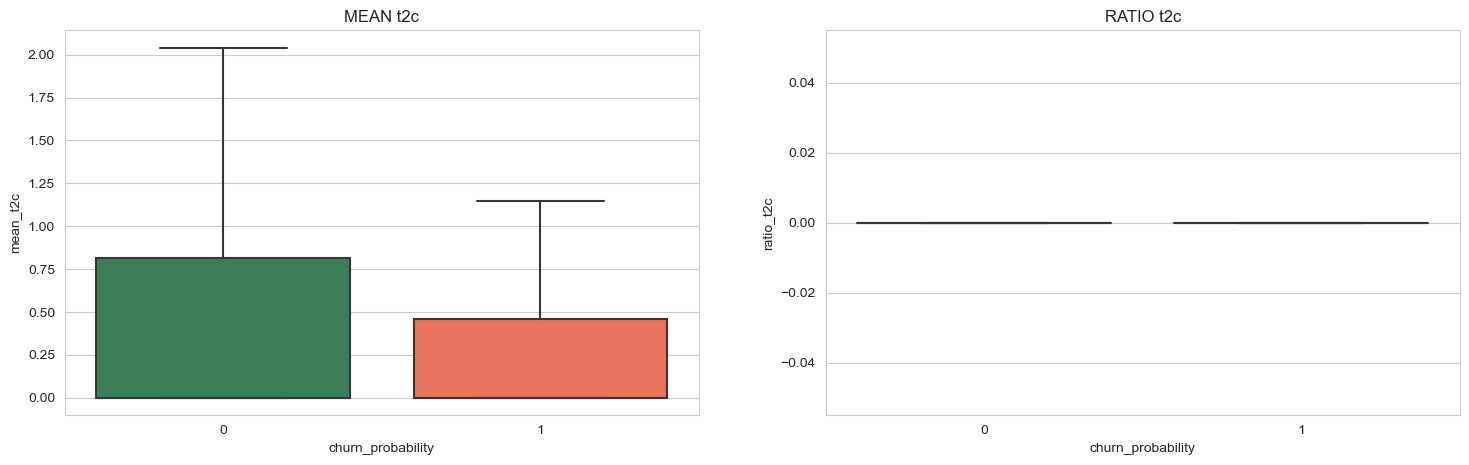

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='mean_t2c', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='ratio_t2c', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])

axes[0].set_title('MEAN t2c')
axes[1].set_title('RATIO t2c')

In [100]:
preproc_cols.extend(t2c)
len(preproc_cols)

45

### 9. ARPU <a class="anchor"  id="9"></a>

In [101]:
arpu = ['arpu_6', 'arpu_7', 'arpu_8']

In [102]:
df[arpu].isnull().mean()

arpu_6    0.0
arpu_7    0.0
arpu_8    0.0
dtype: float64

In [103]:
df.groupby('churn_probability')[['arpu_6', 'arpu_7', 'arpu_8']].mean()

,arpu_6,arpu_7,arpu_8
churn_probability,,,
0,280.280668,284.891073,297.535694
1,308.289067,219.081400,114.226380


In [104]:
df.groupby('churn_probability')[['arpu_6', 'arpu_7', 'arpu_8']].median()

,arpu_6,arpu_7,arpu_8
churn_probability,,,
0,196.1250,198.916,210.0260
1,210.6765,118.348,9.9695


Text(0.5, 1.0, 'ARPU 8m')

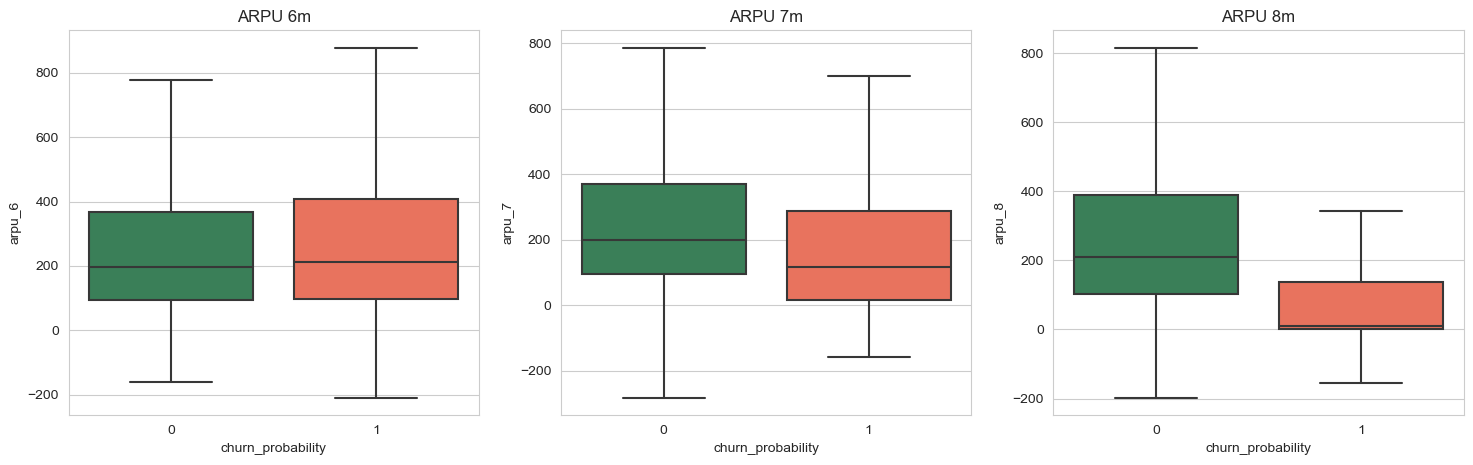

In [105]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='arpu_6', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='arpu_7', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])
sns.boxplot(data=df, x='churn_probability', y='arpu_8', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[2])

axes[0].set_title('ARPU 6m')
axes[1].set_title('ARPU 7m')
axes[2].set_title('ARPU 8m')

In [106]:
df['mean_arpu'] = df[arpu].mean(axis=1)
df['median_arpu'] = df[arpu].median(axis=1)

In [107]:
ratio_column(df, 'ratio_arpu', ['arpu_8'], ['arpu_7', 'arpu_6'], 133000)

Text(0.5, 1.0, 'RATIO ARPU')

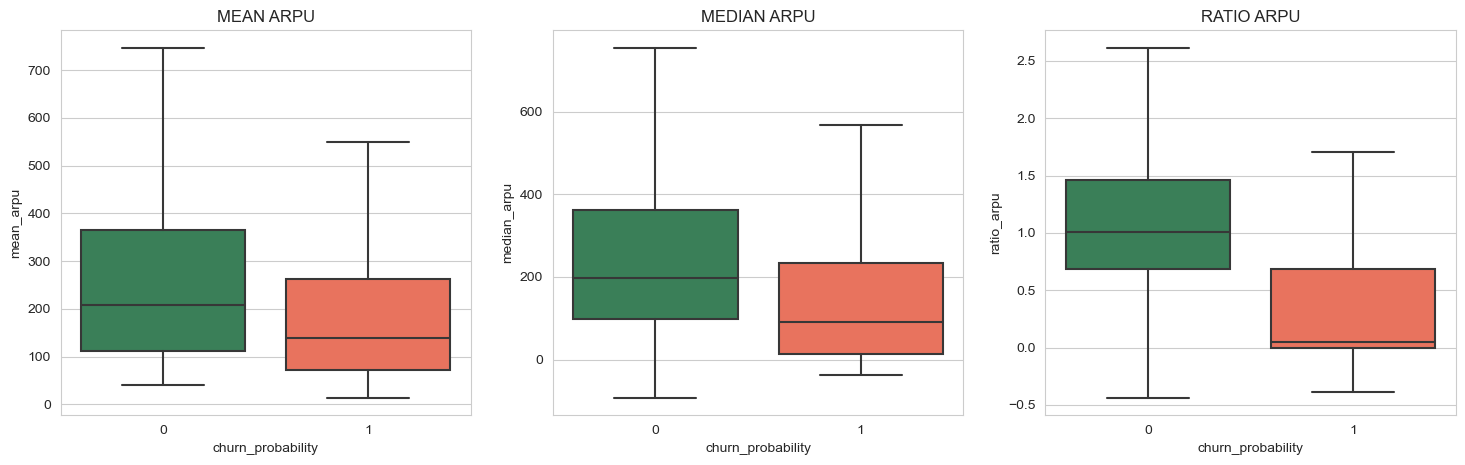

In [108]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='mean_arpu', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='median_arpu', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])
sns.boxplot(data=df, x='churn_probability', y='ratio_arpu', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[2])


axes[0].set_title('MEAN ARPU')
axes[1].set_title('MEDIAN ARPU')
axes[2].set_title('RATIO ARPU')

In [109]:
preproc_cols.extend(arpu)
len(preproc_cols)

48

### 10. ONNET <a class="anchor"  id="10"></a>

In [110]:
onnet = ['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']

In [111]:
df[onnet].isnull().mean()

onnet_mou_6    0.039543
onnet_mou_7    0.038386
onnet_mou_8    0.052901
dtype: float64

In [112]:
df.groupby('churn_probability')[onnet].mean()

,onnet_mou_6,onnet_mou_7,onnet_mou_8
churn_probability,,,
0,127.231453,132.755677,136.240947
1,191.239495,146.320051,84.629559


In [113]:
df.groupby('churn_probability')[onnet].median()

,onnet_mou_6,onnet_mou_7,onnet_mou_8
churn_probability,,,
0,33.190,32.74,33.91
1,46.385,26.03,9.34


Text(0.5, 1.0, 'ONNET MOU 8m')

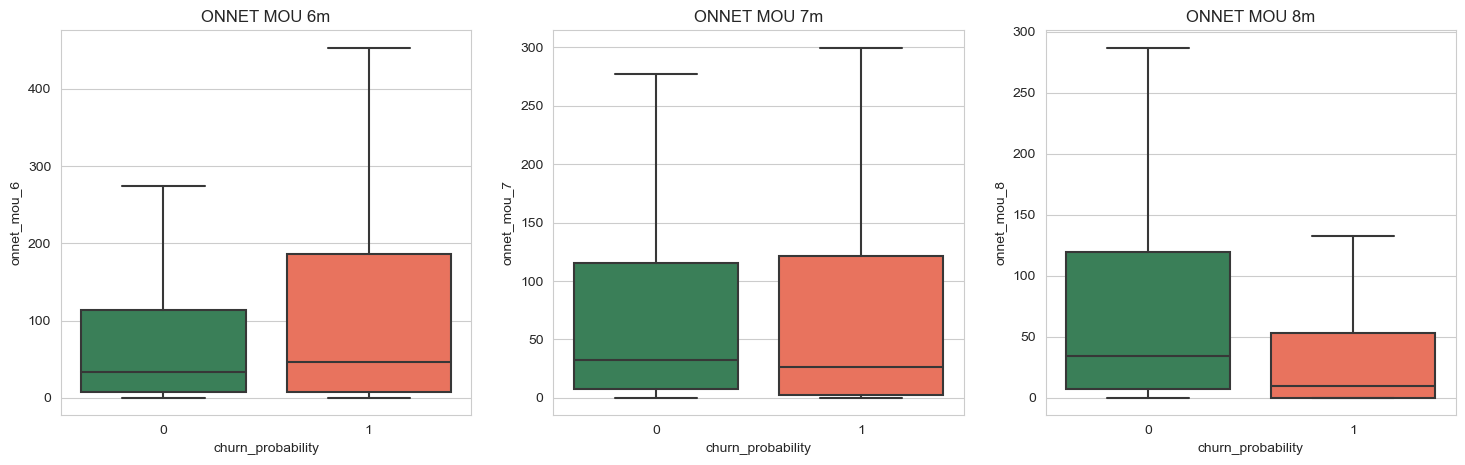

In [114]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='onnet_mou_6', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='onnet_mou_7', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])
sns.boxplot(data=df, x='churn_probability', y='onnet_mou_8', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[2])

axes[0].set_title('ONNET MOU 6m')
axes[1].set_title('ONNET MOU 7m')
axes[2].set_title('ONNET MOU 8m')

In [115]:
df['mean_onnet'] = df[onnet].mean(axis=1)
df['median_onnet'] = df[onnet].median(axis=1)

In [116]:
ratio_column(df, 'ratio_onnet', ['onnet_mou_8'], ['onnet_mou_7', 'onnet_mou_6'], 150000)

Text(0.5, 1.0, 'RATIO ONNET')

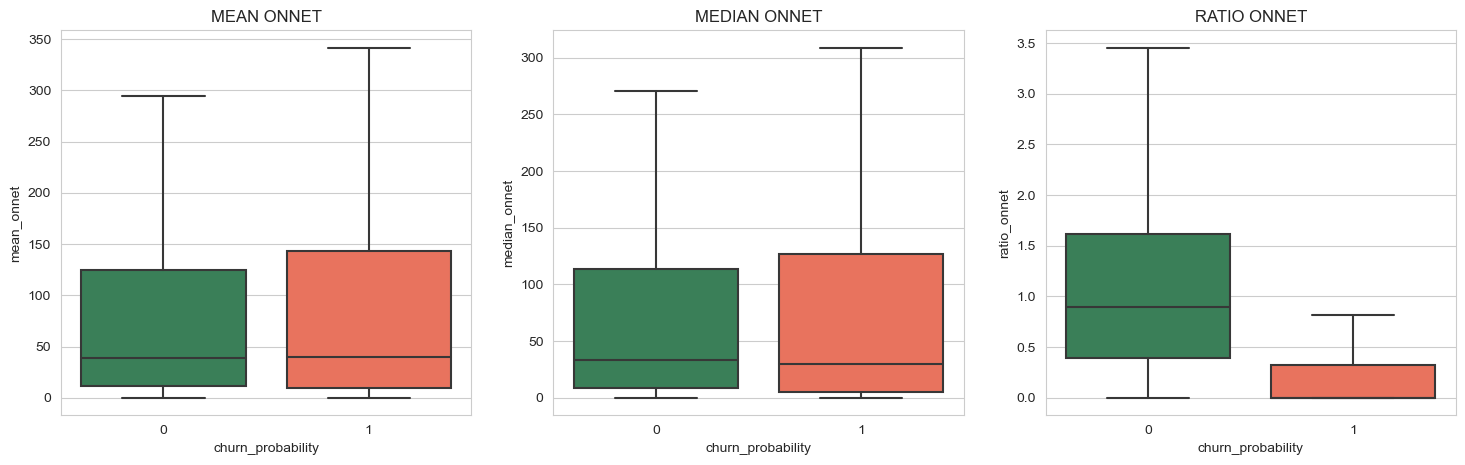

In [117]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='mean_onnet', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='median_onnet', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])
sns.boxplot(data=df, x='churn_probability', y='ratio_onnet', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[2])

axes[0].set_title('MEAN ONNET')
axes[1].set_title('MEDIAN ONNET')
axes[2].set_title('RATIO ONNET')

In [118]:
preproc_cols.extend(onnet)
len(preproc_cols)

51

### 11. OFFNET <a class="anchor"  id="11"></a>

In [119]:
offnet = ['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']

In [120]:
df[offnet].isnull().mean()

offnet_mou_6    0.039543
offnet_mou_7    0.038386
offnet_mou_8    0.052901
dtype: float64

In [121]:
df.groupby('churn_probability')[offnet].mean()

,offnet_mou_6,offnet_mou_7,offnet_mou_8
churn_probability,,,
0,194.773816,198.307128,202.655000
1,239.100389,184.564268,105.980477


In [122]:
df.groupby('churn_probability')[offnet].median()

,offnet_mou_6,offnet_mou_7,offnet_mou_8
churn_probability,,,
0,95.790,94.59,97.26
1,105.055,61.98,25.39


Text(0.5, 1.0, 'OFFNET 8m')

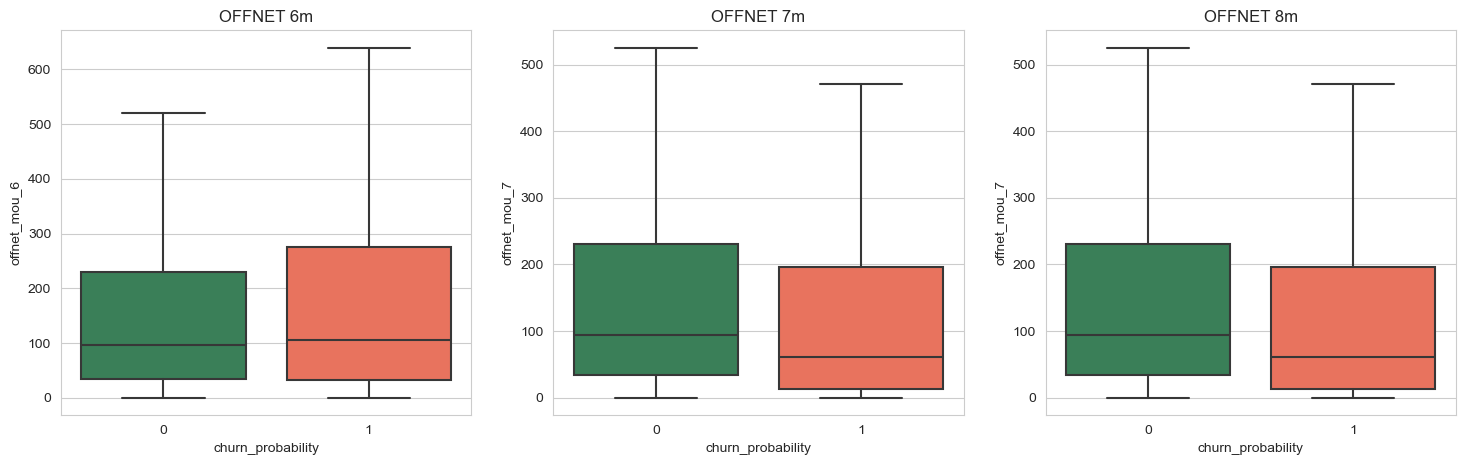

In [123]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='offnet_mou_6', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='offnet_mou_7', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])
sns.boxplot(data=df, x='churn_probability', y='offnet_mou_7', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[2])

axes[0].set_title('OFFNET 6m')
axes[1].set_title('OFFNET 7m')
axes[2].set_title('OFFNET 8m')

In [124]:
df['mean_offnet'] = df[offnet].mean(axis=1)
df['median_offnet'] = df[offnet].median(axis=1)

In [125]:
ratio_column(df, 'ratio_offnet', ['offnet_mou_8'], ['offnet_mou_6', 'offnet_mou_7'], 200000)


Text(0.5, 1.0, 'RATIO OFFNET')

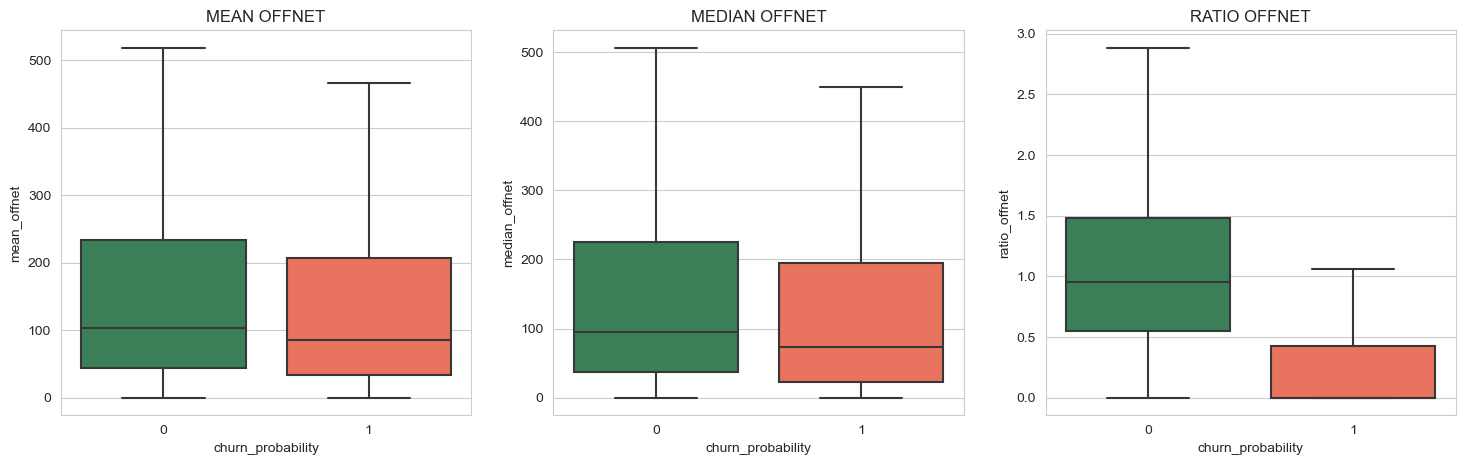

In [126]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='mean_offnet', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='median_offnet', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])
sns.boxplot(data=df, x='churn_probability', y='ratio_offnet', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[2])

axes[0].set_title('MEAN OFFNET')
axes[1].set_title('MEDIAN OFFNET')
axes[2].set_title('RATIO OFFNET')

In [127]:
preproc_cols.extend(offnet)
len(preproc_cols)

54

### 12. ISD <a class="anchor"  id="12"></a>

In [128]:
df.columns[df.columns.str.contains('isd')]

Index(['isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'isd_ic_mou_6',
       'isd_ic_mou_7', 'isd_ic_mou_8'],
      dtype='object')

In [129]:
isd = ['isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 
       'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8']

In [130]:
df[isd].isnull().mean()

isd_og_mou_6    0.039543
isd_og_mou_7    0.038386
isd_og_mou_8    0.052901
isd_ic_mou_6    0.039543
isd_ic_mou_7    0.038386
isd_ic_mou_8    0.052901
dtype: float64

In [131]:
df[isd] = df[isd].fillna(0)

In [132]:
df.groupby('churn_probability')[isd].mean()

,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8
churn_probability,,,,,,
0,0.744780,0.769409,0.828398,7.073136,8.062448,8.434649
1,1.407658,0.873006,0.521457,7.354233,6.050941,3.253790


In [133]:
df.groupby('churn_probability')[isd].median()

,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8
churn_probability,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0


In [134]:
df['mean_isd'] = df[isd].mean(axis=1)

In [135]:
ratio_column(df, 'ratio_isd', ['isd_og_mou_8', 'isd_ic_mou_8'], 
             ['isd_og_mou_6', 'isd_og_mou_7', 'isd_ic_mou_6', 'isd_ic_mou_7'], 30000)


Text(0.5, 1.0, 'RATIO ISD')

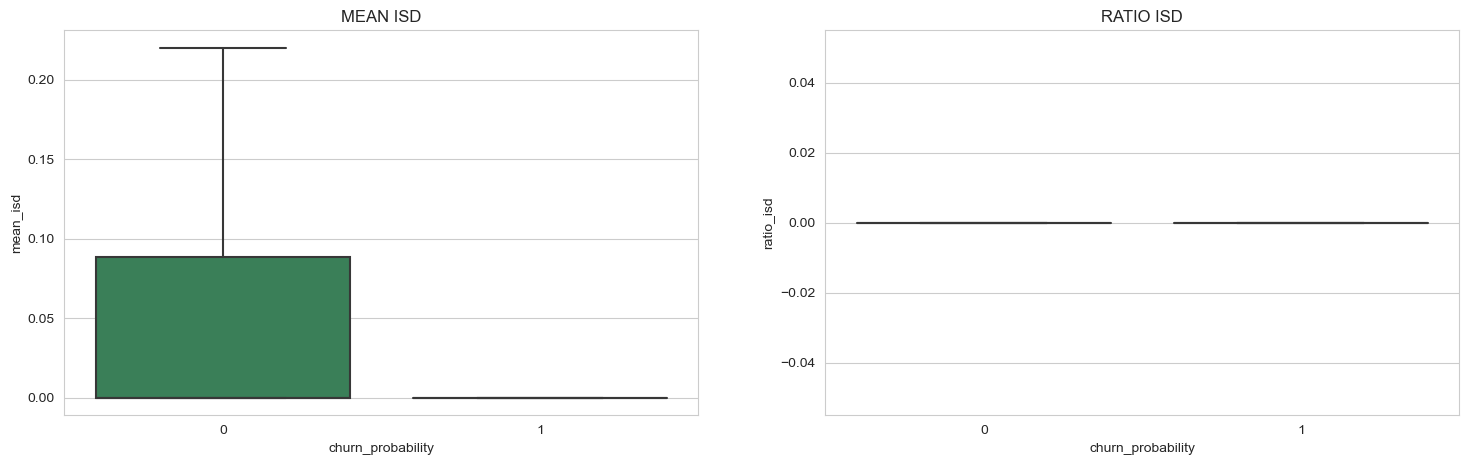

In [136]:
fig, axes = plt.subplots(1, 2, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='mean_isd', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='ratio_isd', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])

axes[0].set_title('MEAN ISD')
axes[1].set_title('RATIO ISD')

In [137]:
preproc_cols.extend(isd)
len(preproc_cols)

60

### 13. SPL <a class="anchor"  id="13"></a>

In [138]:
df.columns[df.columns.str.contains('spl')]

Index(['spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'spl_ic_mou_6',
       'spl_ic_mou_7', 'spl_ic_mou_8'],
      dtype='object')

In [139]:
spl = ['spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 
       'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8']

In [140]:
df[spl].isnull().mean()

spl_og_mou_6    0.039543
spl_og_mou_7    0.038386
spl_og_mou_8    0.052901
spl_ic_mou_6    0.039543
spl_ic_mou_7    0.038386
spl_ic_mou_8    0.052901
dtype: float64

In [141]:
df[spl] = df[spl].fillna(0)

In [142]:
df.groupby('churn_probability')[spl].mean()

,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8
churn_probability,,,,,,
0,3.765012,4.848017,5.148241,0.061123,0.033552,0.042200
1,4.128840,4.236813,1.515799,0.045025,0.019195,0.003481


In [143]:
df.groupby('churn_probability')[spl].median()

,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8
churn_probability,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'SPL OG MOU 8m')

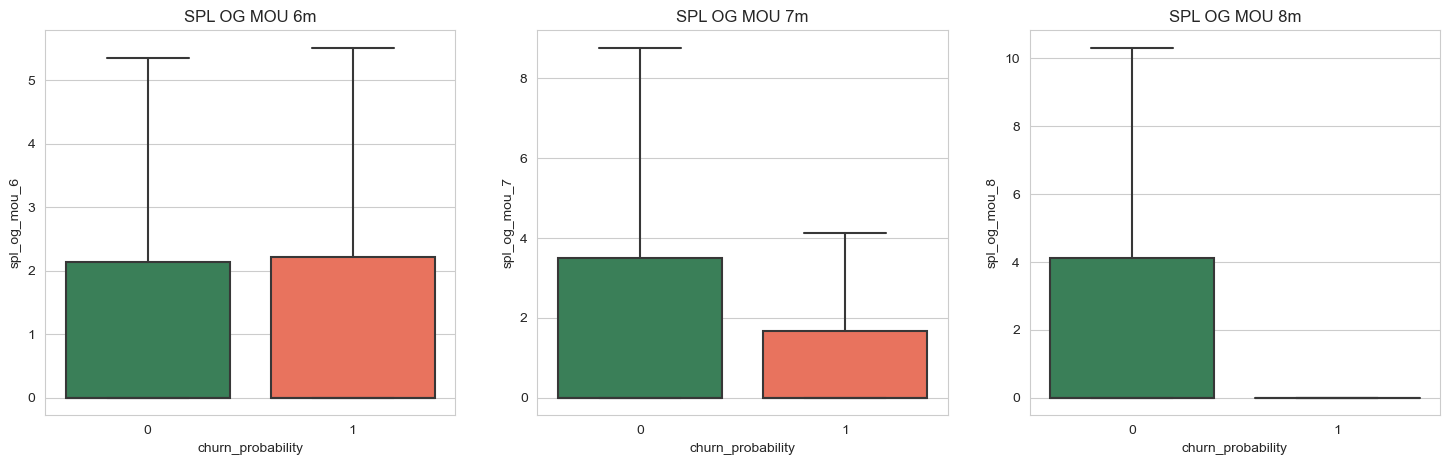

In [144]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='spl_og_mou_6', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='spl_og_mou_7', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])
sns.boxplot(data=df, x='churn_probability', y='spl_og_mou_8', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[2])

axes[0].set_title('SPL OG MOU 6m')
axes[1].set_title('SPL OG MOU 7m')
axes[2].set_title('SPL OG MOU 8m')

In [145]:
df['mean_spl'] = df[spl].mean(axis=1)
#df['median_offnet'] = df[offnet].median(axis=1)

In [146]:
df[spl].head(2)

,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8
0,8.2,0.63,0.00,0.0,0.0,0.66
1,0.0,30.73,31.66,0.0,0.0,0.01


In [147]:
ratio_column(df, 'ratio_spl', ['spl_og_mou_8', 'spl_ic_mou_8'], 
             ['spl_og_mou_6', 'spl_og_mou_7', 'spl_ic_mou_6', 'spl_ic_mou_7'], 20000)


In [148]:
df['ratio_spl'].describe()

count    69999.000000
mean      1895.595315
std       5843.073527
min          0.000000
25%          0.000000
50%          0.077295
75%          4.068670
max      20000.000000
Name: ratio_spl, dtype: float64

Text(0.5, 1.0, 'RATIO SPL')

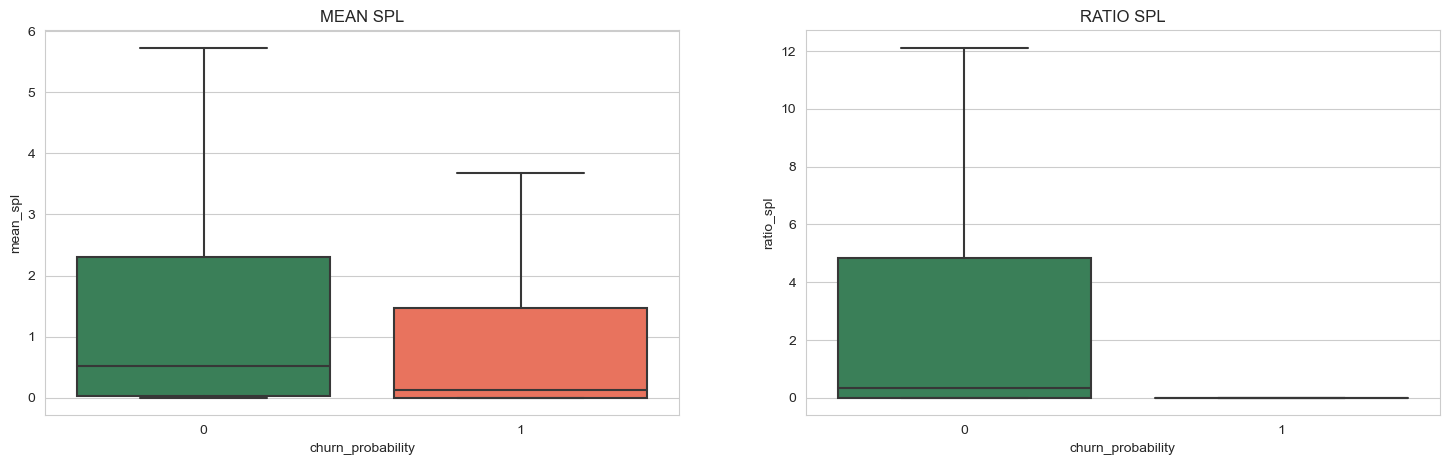

In [149]:
fig, axes = plt.subplots(1, 2, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='mean_spl', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='ratio_spl', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])

axes[0].set_title('MEAN SPL')
axes[1].set_title('RATIO SPL')

In [150]:
preproc_cols.extend(spl)
len(preproc_cols)

66

### 14. TOTAL OG\IC <a class="anchor"  id="14"></a>

In [151]:
df.columns[df.columns.str.contains('total')]

Index(['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'total_ic_mou_6',
       'total_ic_mou_7', 'total_ic_mou_8', 'total_rech_num_6',
       'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6',
       'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_data_6',
       'total_rech_data_7', 'total_rech_data_8'],
      dtype='object')

In [152]:
total_calls = ['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 
               'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']

In [153]:
df[total_calls].isnull().mean()

total_og_mou_6    0.0
total_og_mou_7    0.0
total_og_mou_8    0.0
total_ic_mou_6    0.0
total_ic_mou_7    0.0
total_ic_mou_8    0.0
dtype: float64

In [154]:
df.groupby('churn_probability')[total_calls].mean()

,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8
churn_probability,,,,,,
0,301.242079,318.252422,328.550893,206.643635,213.892542,216.701665
1,352.370766,242.877399,92.624937,138.597825,95.972761,37.919282


In [155]:
df.groupby('churn_probability')[total_calls].median()

,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8
churn_probability,,,,,,
0,145.73,151.23,159.96,121.910,127.580,131.24
1,138.91,38.79,0.00,54.135,22.155,0.00


In [156]:
df['mean_total_calls'] = df[total_calls].mean(axis=1)
df['median_total_calls'] = df[total_calls].median(axis=1)

In [157]:
df[total_calls].head(2)

,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8
0,81.21,221.68,3.63,11.84,53.04,40.56
1,0.00,30.73,31.66,3.44,39.44,25.04


In [158]:
ratio_column(df, 'ratio_total_calls', ['total_og_mou_8', 'total_ic_mou_8'], 
             ['total_og_mou_6', 'total_og_mou_7', 'total_ic_mou_6', 'total_ic_mou_7'], 100000)

Text(0.5, 1.0, 'RATIO Total calls')

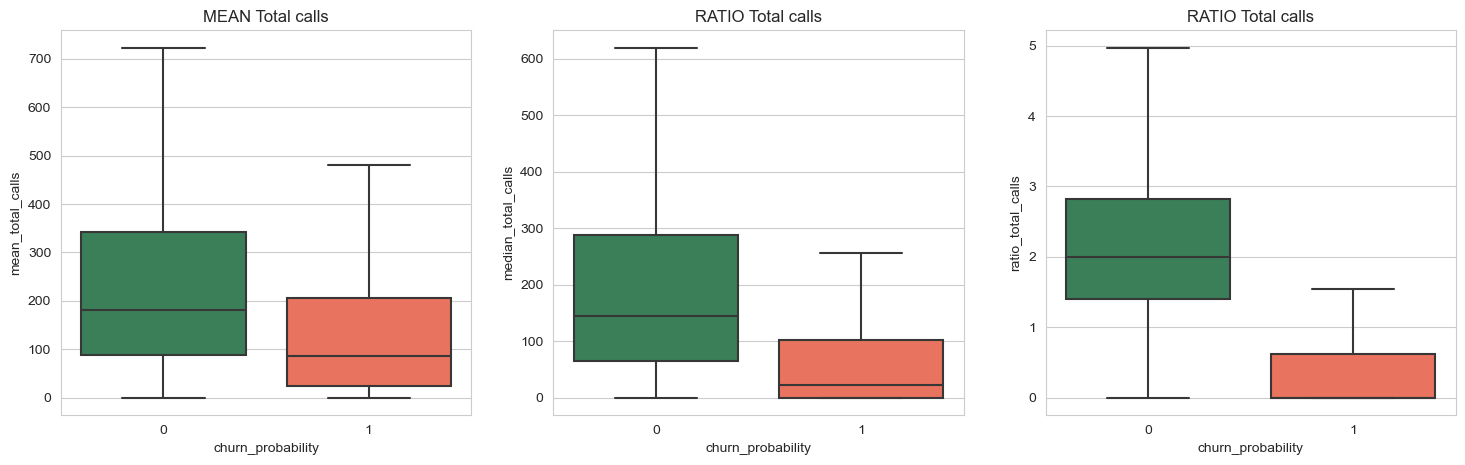

In [159]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='mean_total_calls', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='median_total_calls', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])
sns.boxplot(data=df, x='churn_probability', y='ratio_total_calls', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[2])

axes[0].set_title('MEAN Total calls')
axes[1].set_title('RATIO Total calls')
axes[2].set_title('RATIO Total calls')

In [160]:
preproc_cols.extend(total_calls)
len(preproc_cols)

72

###  15. LOC OG\IC <a class="anchor"  id="15"></a>

In [161]:
loc_og_ic = ['loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8']

In [162]:
df[loc_og_ic].isnull().mean()

loc_og_mou_6    0.039543
loc_og_mou_7    0.038386
loc_og_mou_8    0.052901
loc_ic_mou_6    0.039543
loc_ic_mou_7    0.038386
loc_ic_mou_8    0.052901
dtype: float64

In [163]:
df[loc_og_ic] = df[loc_og_ic].fillna(0)

In [164]:
df.groupby('churn_probability')[loc_og_ic].mean()

,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8
churn_probability,,,,,,
0,144.513335,144.475110,145.625253,167.780504,171.177604,173.349661
1,82.584096,54.887182,22.154563,97.710658,66.739523,25.592482


In [165]:
df.groupby('churn_probability')[loc_og_ic].median()

,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8
churn_probability,,,,,,
0,65.36,66.090,67.54,93.59,96.54,99.48
1,21.92,6.395,0.00,30.01,11.05,0.00


In [166]:
df['mean_loc_og_ic'] = df[loc_og_ic].mean(axis=1)
df['median_loc_og_ic'] = df[loc_og_ic].median(axis=1)

In [167]:
ratio_column(df, 'ratio_loc_og_ic', ['loc_og_mou_8', 'loc_ic_mou_8'], 
             ['loc_og_mou_6', 'loc_og_mou_7', 'loc_ic_mou_6', 'loc_ic_mou_7'], 15000)

Text(0.5, 1.0, 'RATIO LOC OG\\IC')

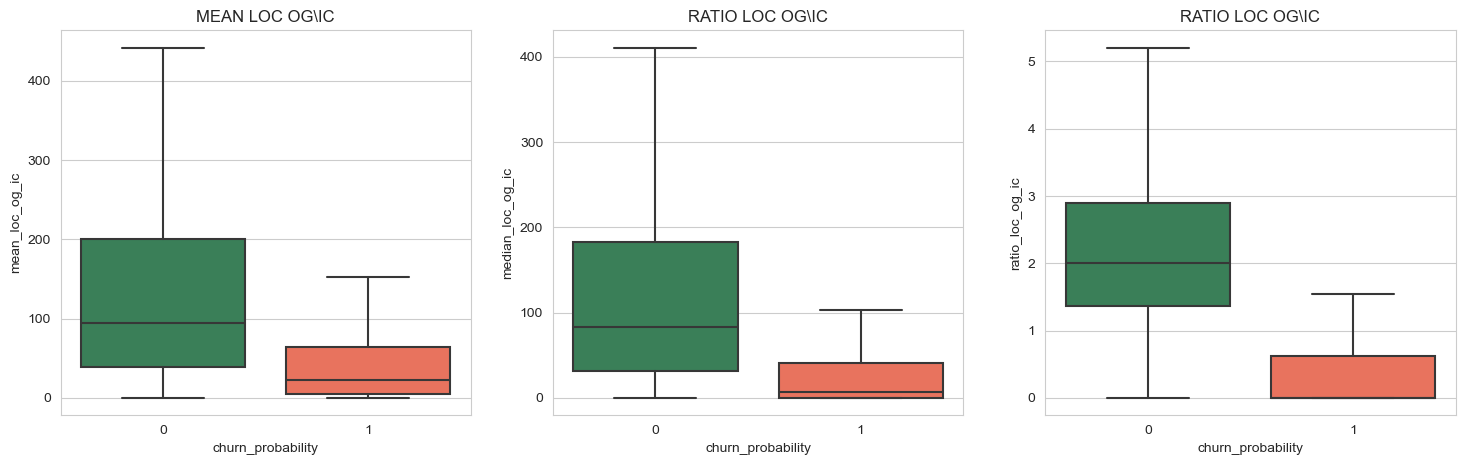

In [168]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='mean_loc_og_ic', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='median_loc_og_ic', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])
sns.boxplot(data=df, x='churn_probability', y='ratio_loc_og_ic', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[2])

axes[0].set_title('MEAN LOC OG\IC')
axes[1].set_title('RATIO LOC OG\IC')
axes[2].set_title('RATIO LOC OG\IC')

In [169]:
preproc_cols.extend(loc_og_ic)
len(preproc_cols)

78

###  16. STD OG\IC <a class="anchor"  id="16"></a>

In [170]:
std_og_ic = ['std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8']

In [171]:
df[std_og_ic].isnull().mean()

std_og_mou_6    0.039543
std_og_mou_7    0.038386
std_og_mou_8    0.052901
std_ic_mou_6    0.039543
std_ic_mou_7    0.038386
std_ic_mou_8    0.052901
dtype: float64

In [172]:
df[std_og_ic] = df[std_og_ic].fillna(0)

In [173]:
df.groupby('churn_probability')[std_og_ic].mean()

,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8
churn_probability,,,,,,
0,151.780469,168.128378,176.907384,30.877593,33.581950,33.876684
1,263.685440,182.864829,68.430024,32.873814,22.617936,8.854362


In [174]:
df.groupby('churn_probability')[std_og_ic].median()

,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8
churn_probability,,,,,,
0,8.39,9.53,10.79,5.090,5.75,6.16
1,33.05,0.63,0.00,4.205,0.20,0.00


In [175]:
df['mean_std_og_ic'] = df[std_og_ic].mean(axis=1)
df['median_std_og_ic'] = df[std_og_ic].median(axis=1)

In [176]:
ratio_column(df, 'ratio_std_og_ic', ['std_og_mou_8', 'std_ic_mou_8'], 
             ['std_og_mou_6', 'std_og_mou_7', 'std_ic_mou_6', 'std_ic_mou_7'], 45000)

Text(0.5, 1.0, 'RATIO STD OG\\IC')

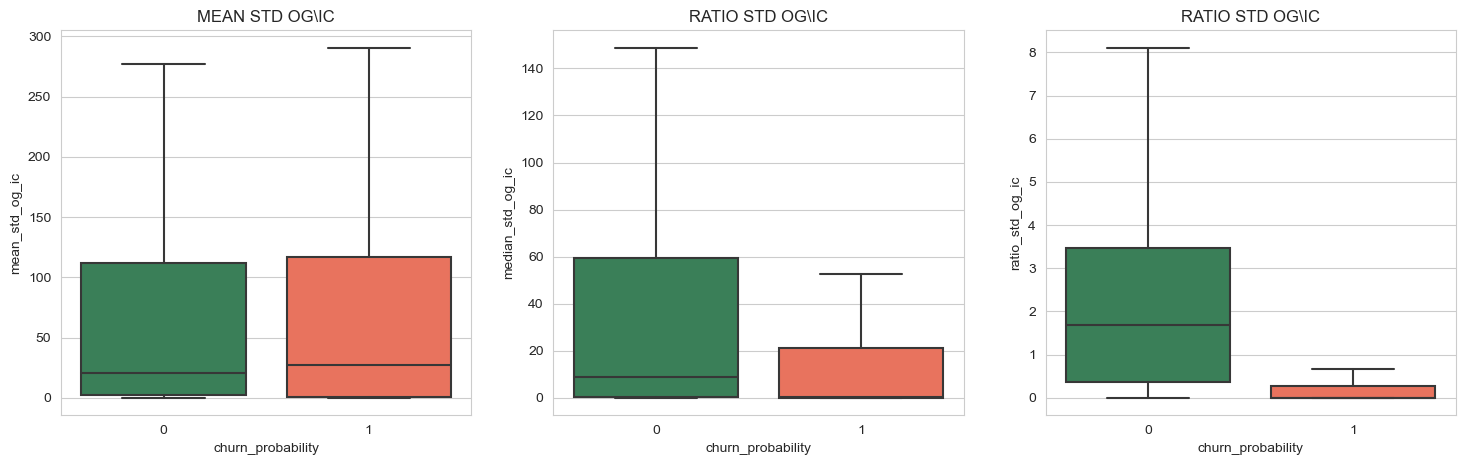

In [177]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='mean_std_og_ic', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='median_std_og_ic', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])
sns.boxplot(data=df, x='churn_probability', y='ratio_std_og_ic', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[2])

axes[0].set_title('MEAN STD OG\IC')
axes[1].set_title('RATIO STD OG\IC')
axes[2].set_title('RATIO STD OG\IC')

In [178]:
preproc_cols.extend(std_og_ic)
len(preproc_cols)

84

In [179]:
###og_others_6	og_others_7	og_others_8	ic_others_6	ic_others_7	ic_others_8

###  17. OTHERS <a class="anchor"  id="17"></a>

In [180]:
others_og_ic = ['og_others_6', 'og_others_7', 'og_others_8', 'ic_others_6', 'ic_others_7', 'ic_others_8']

In [181]:
df[others_og_ic].isnull().mean()

og_others_6    0.039543
og_others_7    0.038386
og_others_8    0.052901
ic_others_6    0.039543
ic_others_7    0.038386
ic_others_8    0.052901
dtype: float64

In [182]:
df[others_og_ic] = df[others_og_ic].fillna(0)

In [183]:
df.groupby('churn_probability')[others_og_ic].mean()

,og_others_6,og_others_7,og_others_8,ic_others_6,ic_others_7,ic_others_8
churn_probability,,,,,,
0,0.431444,0.024944,0.034802,0.844351,1.030408,0.991567
1,0.557518,0.010646,0.000530,0.608204,0.540949,0.213177


In [184]:
df.groupby('churn_probability')[others_og_ic].median()

,og_others_6,og_others_7,og_others_8,ic_others_6,ic_others_7,ic_others_8
churn_probability,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0


In [185]:
df['mean_others_og_ic'] = df[others_og_ic].mean(axis=1)
#df['median_std_og_ic'] = df[std_og_ic].median(axis=1)

In [186]:
ratio_column(df, 'ratio_others_og_ic', ['og_others_8', 'ic_others_8'], 
             ['og_others_6', 'og_others_7', 'ic_others_6', 'ic_others_7'], 7300)

Text(0.5, 1.0, 'RATIO OTHERS OG\\IC')

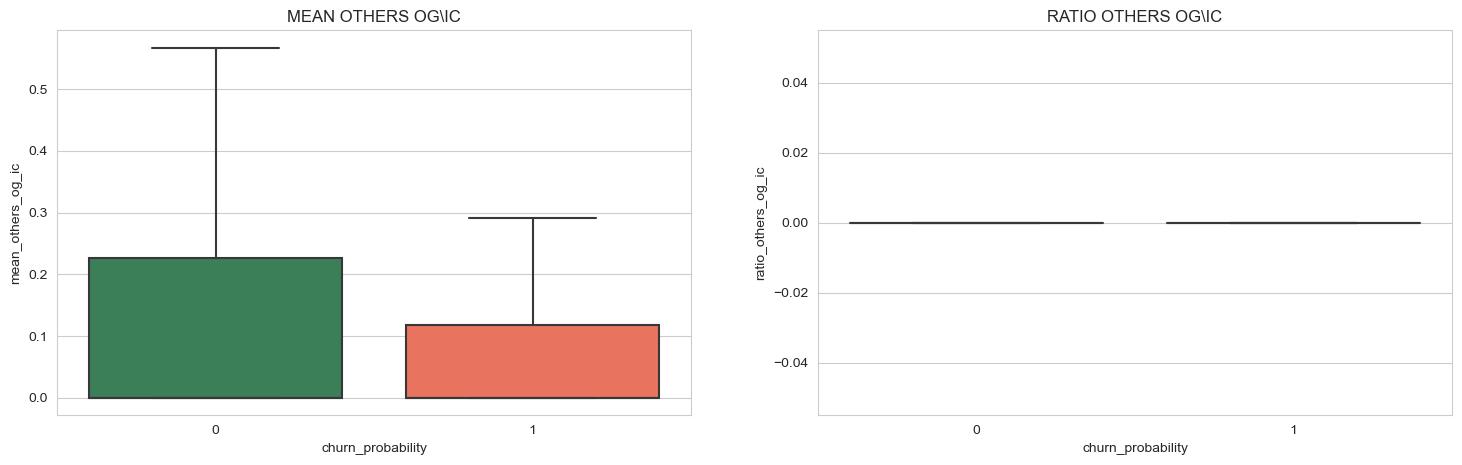

In [187]:
fig, axes = plt.subplots(1, 2, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='mean_others_og_ic', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='ratio_others_og_ic', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])

axes[0].set_title('MEAN OTHERS OG\IC')
axes[1].set_title('RATIO OTHERS OG\IC')

In [188]:
preproc_cols.extend(others_og_ic)
len(preproc_cols)

90

### 18. RECH AMT <a class="anchor"  id="18"></a>

In [189]:
df.columns[df.columns.str.contains('rech')]

Index(['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
       'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',
       'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8',
       'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
       'last_rech_days', 'last_rech_data_days'],
      dtype='object')

In [190]:
reach_amt = ['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8']

In [191]:
df[reach_amt].isnull().mean()

total_rech_amt_6    0.0
total_rech_amt_7    0.0
total_rech_amt_8    0.0
dtype: float64

In [192]:
df.groupby('churn_probability')[reach_amt].mean()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8
churn_probability,,,
0,325.570888,331.234352,346.878712
1,350.784072,244.295149,120.821228


In [193]:
df.groupby('churn_probability')[reach_amt].median()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8
churn_probability,,,
0,228.0,230.0,250.0
1,236.0,120.0,0.0


In [194]:
df['mean_reach_amt'] = df[reach_amt].mean(axis=1)
df['median_reach_amt'] = df[reach_amt].median(axis=1)

In [195]:
ratio_column(df, 'ratio_reach_amt', ['total_rech_amt_8'], ['total_rech_amt_6', 'total_rech_amt_7'], 200)

Text(0.5, 1.0, 'RATIO REACH AMT')

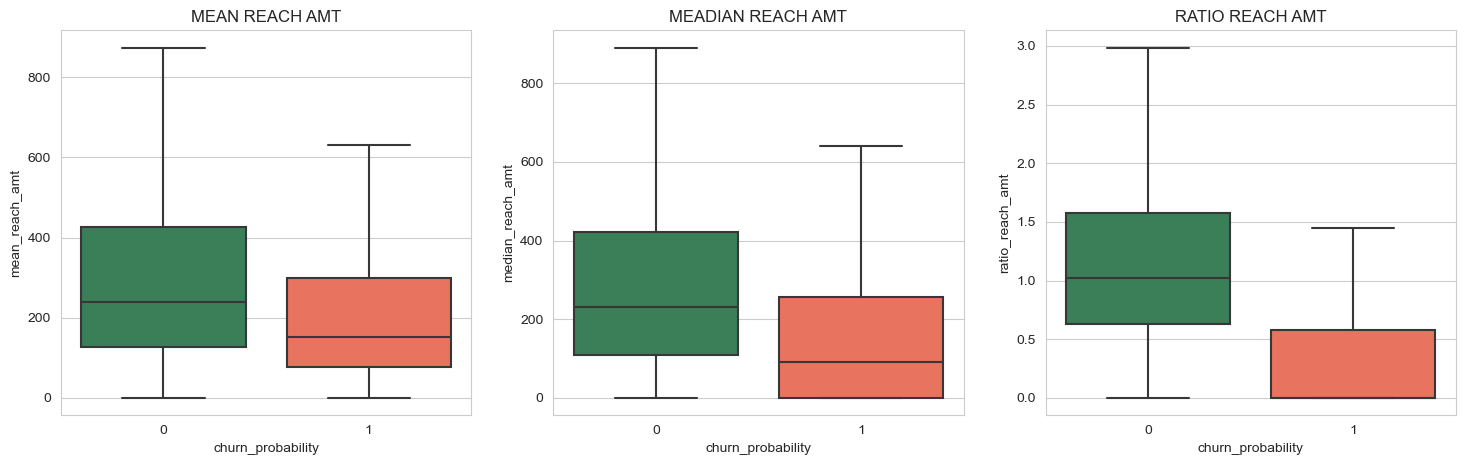

In [196]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='mean_reach_amt', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='median_reach_amt', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])
sns.boxplot(data=df, x='churn_probability', y='ratio_reach_amt', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[2])

axes[0].set_title('MEAN REACH AMT')
axes[1].set_title('MEADIAN REACH AMT')
axes[2].set_title('RATIO REACH AMT')

In [197]:
preproc_cols.extend(reach_amt)
len(preproc_cols)

93

### 19. RECH NUM <a class="anchor"  id="19"></a>

In [198]:
reach_num = ['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8']

In [199]:
df[reach_num].isnull().mean()

total_rech_num_6    0.0
total_rech_num_7    0.0
total_rech_num_8    0.0
dtype: float64

In [200]:
df.groupby('churn_probability')[reach_num].mean()

,total_rech_num_6,total_rech_num_7,total_rech_num_8
churn_probability,,,
0,7.504939,7.856173,7.629774
1,8.109366,6.388811,3.656338


In [201]:
df.groupby('churn_probability')[reach_num].median()

,total_rech_num_6,total_rech_num_7,total_rech_num_8
churn_probability,,,
0,6.0,6.0,5.0
1,6.0,4.0,3.0


In [202]:
df['mean_reach_num'] = df[reach_num].mean(axis=1)
df['median_reach_num'] = df[reach_num].median(axis=1)

In [203]:
ratio_column(df, 'ratio_reach_num', ['total_rech_num_8'], ['total_rech_num_6', 'total_rech_num_7'], 70)

Text(0.5, 1.0, 'RATIO REACH NUM')

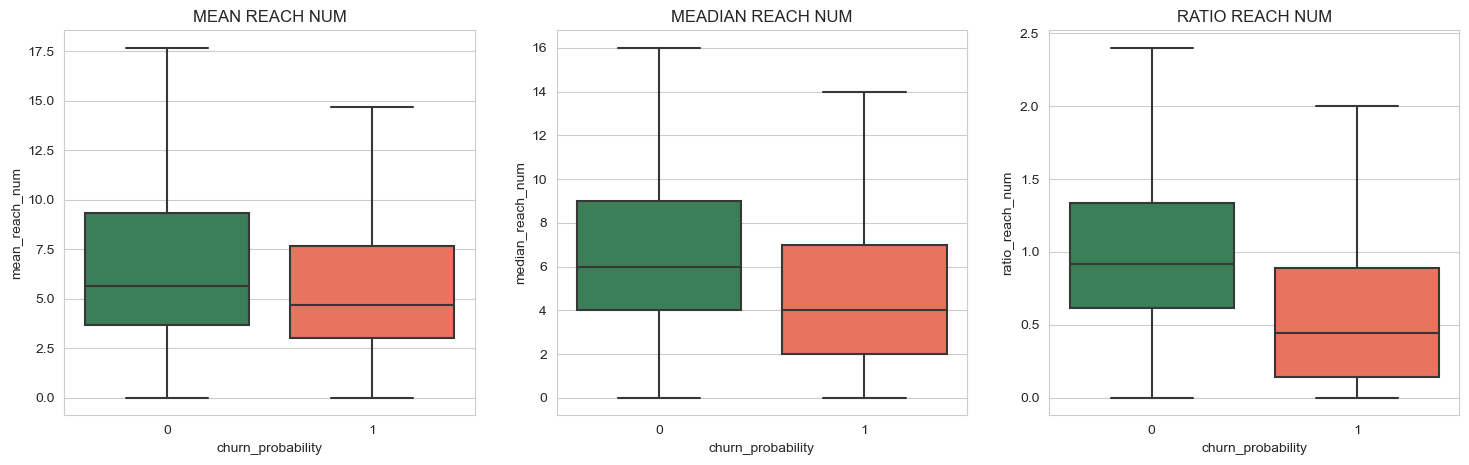

In [204]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='mean_reach_num', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='median_reach_num', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])
sns.boxplot(data=df, x='churn_probability', y='ratio_reach_num', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[2])

axes[0].set_title('MEAN REACH NUM')
axes[1].set_title('MEADIAN REACH NUM')
axes[2].set_title('RATIO REACH NUM')

In [205]:
preproc_cols.extend(reach_num)
len(preproc_cols)

96

### 20. RECH DATA TOTAL <a class="anchor"  id="20"></a>

In [206]:
reach_data = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8']

In [207]:
df[reach_data].isnull().mean()

total_rech_data_6    0.749025
total_rech_data_7    0.744782
total_rech_data_8    0.736896
dtype: float64

In [208]:
df[reach_data] = df[reach_data].fillna(0)

In [209]:
df.groupby('churn_probability')[reach_data].mean()

,total_rech_data_6,total_rech_data_7,total_rech_data_8
churn_probability,,,
0,0.629551,0.714063,0.758045
1,0.529024,0.418817,0.167414


In [210]:
df.groupby('churn_probability')[reach_data].median()

,total_rech_data_6,total_rech_data_7,total_rech_data_8
churn_probability,,,
0,0.0,0.0,0.0
1,0.0,0.0,0.0


In [211]:
df['mean_reach_data'] = df[reach_data].mean(axis=1)
#df['median_reach_num'] = df[reach_num].median(axis=1)

In [212]:
ratio_column(df, 'ratio_reach_data', ['total_rech_data_8'], ['total_rech_data_6', 'total_rech_data_7'], 50)

Text(0.5, 1.0, 'RATIO REACH DATA')

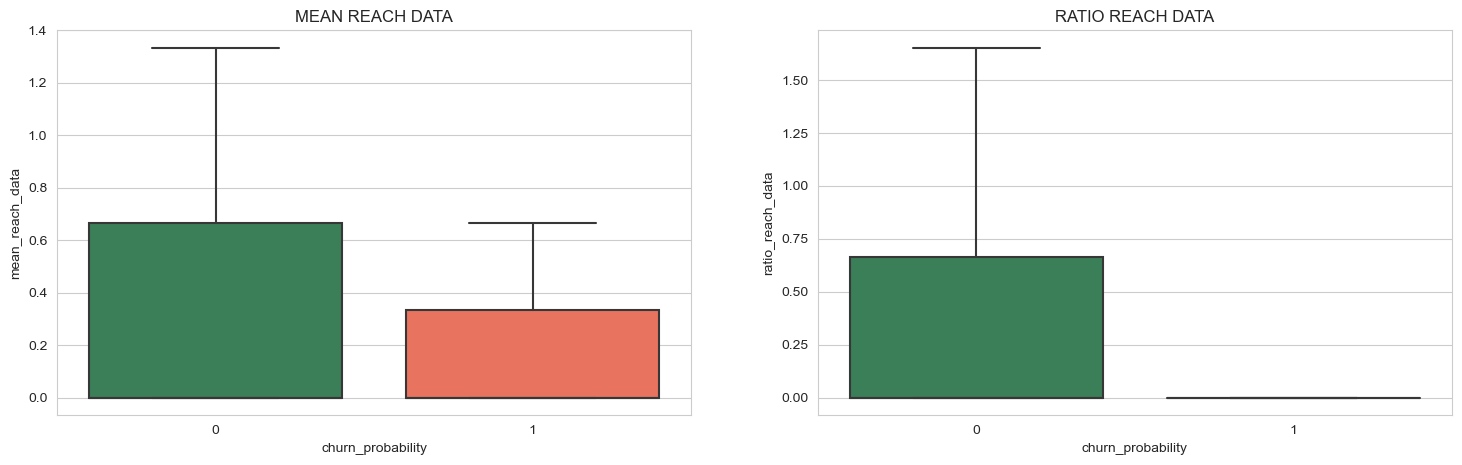

In [213]:
fig, axes = plt.subplots(1, 2, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='mean_reach_data', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='ratio_reach_data', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])

axes[0].set_title('MEAN REACH DATA')
axes[1].set_title('RATIO REACH DATA')

In [214]:
preproc_cols.extend(reach_data)
len(preproc_cols)

99

### 21. LAST DAY REACH AMT <a class="anchor"  id="21"></a>

In [215]:
last_day_reach = ['last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8']

Text(0.5, 1.0, 'LAST DAY REACH 8')

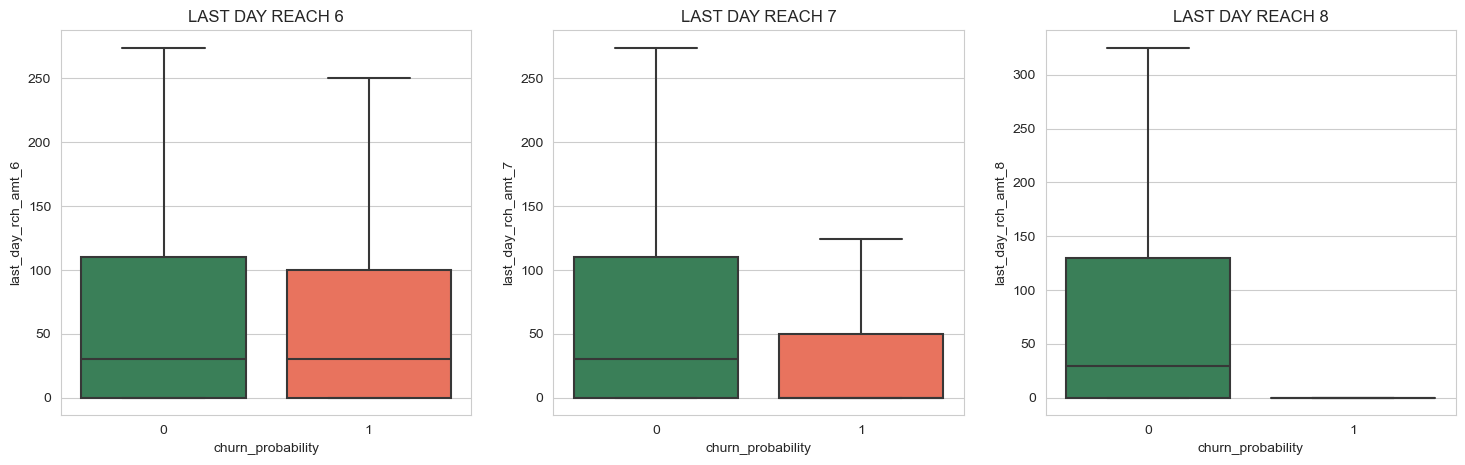

In [216]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='last_day_rch_amt_6', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='last_day_rch_amt_7', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])
sns.boxplot(data=df, x='churn_probability', y='last_day_rch_amt_8', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[2])

axes[0].set_title('LAST DAY REACH 6')
axes[1].set_title('LAST DAY REACH 7')
axes[2].set_title('LAST DAY REACH 8')

In [217]:
ratio_column(df, 'ratio_reach_last_day', ['last_day_rch_amt_8'], ['last_day_rch_amt_6', 'last_day_rch_amt_7'], 110)

<AxesSubplot:xlabel='churn_probability', ylabel='ratio_reach_last_day'>

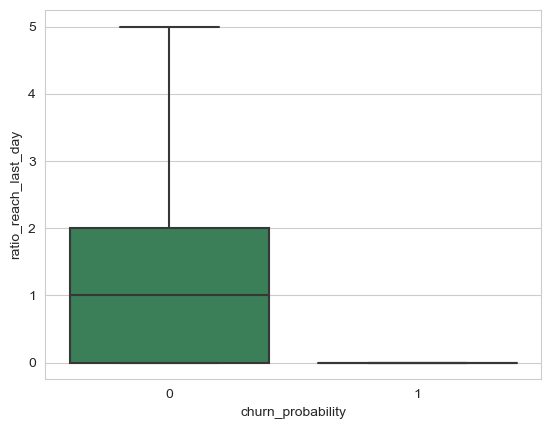

In [218]:
sns.boxplot(data=df, x='churn_probability', y='ratio_reach_last_day', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'})

In [219]:
preproc_cols.extend(last_day_reach)
len(preproc_cols)

102

### 22. RECH 2G AND 3G <a class="anchor"  id="22"></a>

In [220]:
rech_2g_3g = ['count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 
              'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8']

In [221]:
df[rech_2g_3g].isnull().mean()

count_rech_2g_6    0.749025
count_rech_2g_7    0.744782
count_rech_2g_8    0.736896
count_rech_3g_6    0.749025
count_rech_3g_7    0.744782
count_rech_3g_8    0.736896
dtype: float64

In [222]:
df[rech_2g_3g] = df[rech_2g_3g].fillna(0)

In [223]:
df.groupby('churn_probability')[rech_2g_3g].mean()

,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8
churn_probability,,,,,,
0,0.477277,0.549318,0.577203,0.152274,0.164745,0.180842
1,0.387689,0.308749,0.118059,0.141335,0.110067,0.049355


In [224]:
df.groupby('churn_probability')[rech_2g_3g].median()

,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8
churn_probability,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0


In [225]:
df['mean_rech_2g_3g'] = df[rech_2g_3g].mean(axis=1)

In [226]:
ratio_column(df, 'ratio_rech_2g_3g', ['count_rech_2g_8', 'count_rech_3g_8'], 
             ['count_rech_2g_6', 'count_rech_2g_7', 'count_rech_3g_6', 'count_rech_3g_7'], 90)

Text(0.5, 1.0, 'RATIO RECH 2G&3G')

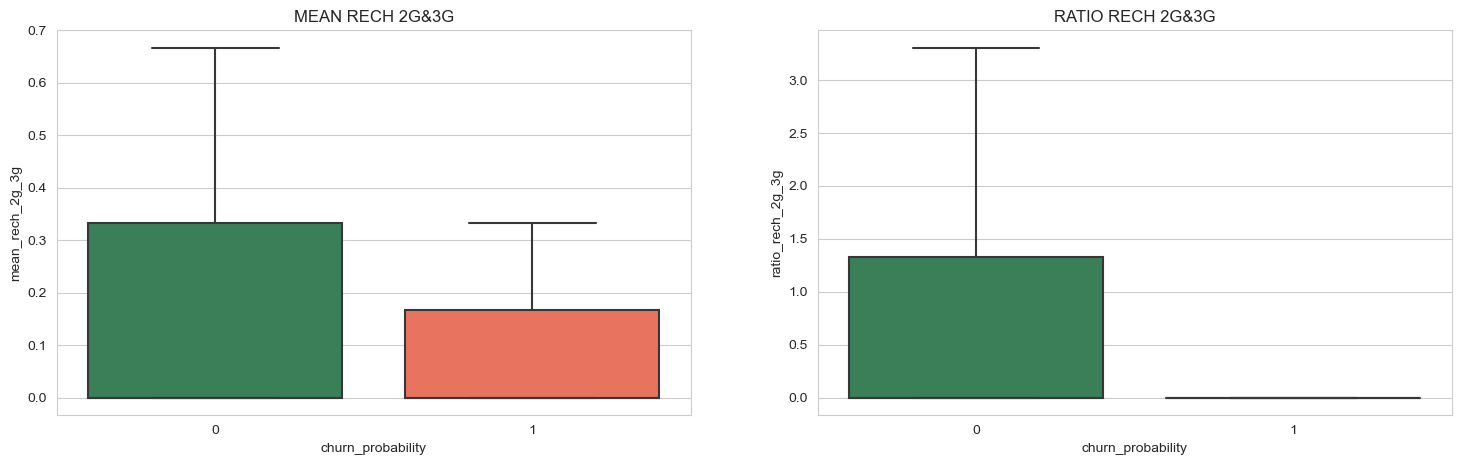

In [227]:
fig, axes = plt.subplots(1, 2, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='mean_rech_2g_3g', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='ratio_rech_2g_3g', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])

axes[0].set_title('MEAN RECH 2G&3G')
axes[1].set_title('RATIO RECH 2G&3G')

In [228]:
preproc_cols.extend(rech_2g_3g)
len(preproc_cols)

108

### 23. VOL 2G&3G <a class="anchor"  id="23"></a>

In [229]:
vol_2g_3g = ['vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8']

In [230]:
df[vol_2g_3g].isnull().mean()

vol_2g_mb_6    0.0
vol_2g_mb_7    0.0
vol_2g_mb_8    0.0
vol_3g_mb_6    0.0
vol_3g_mb_7    0.0
vol_3g_mb_8    0.0
dtype: float64

In [231]:
df.groupby('churn_probability')[vol_2g_3g].mean()

,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8
churn_probability,,,,,,
0,52.993459,53.696628,54.559777,124.938010,135.722042,146.931172
1,41.023999,29.587367,11.058022,97.789079,69.103268,34.604651


In [232]:
df.groupby('churn_probability')[vol_2g_3g].median()

,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8
churn_probability,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0


In [233]:
df['mean_vol_2g_3g'] = df[vol_2g_3g].mean(axis=1)

In [234]:
ratio_column(df, 'ratio_vol_2g_3g', ['vol_2g_mb_8', 'vol_3g_mb_8'], 
             ['vol_2g_mb_6', 'vol_2g_mb_7', 'vol_3g_mb_6', 'vol_3g_mb_7'], 480000)

Text(0.5, 1.0, 'RATIO VOL 2G&3G')

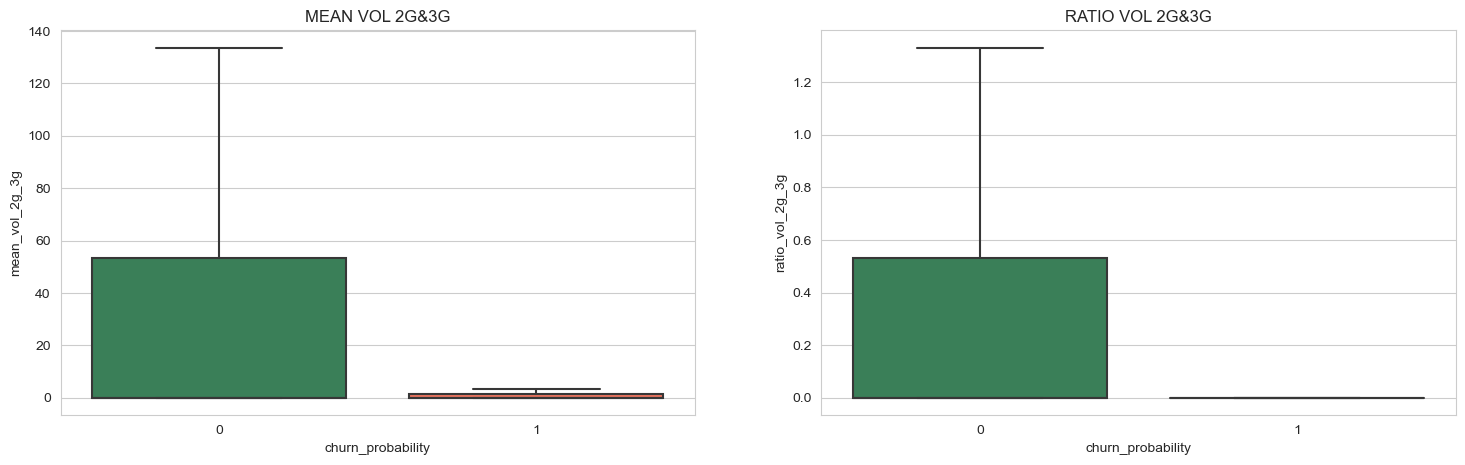

In [235]:
fig, axes = plt.subplots(1, 2, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='mean_vol_2g_3g', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='ratio_vol_2g_3g', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])

axes[0].set_title('MEAN VOL 2G&3G')
axes[1].set_title('RATIO VOL 2G&3G')

In [236]:
preproc_cols.extend(vol_2g_3g)
len(preproc_cols)

114

### 24. ARPU 2G&3G <a class="anchor"  id="24"></a>

In [237]:
arpu_2g_3g = ['arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8']

In [238]:
df[arpu_2g_3g].isnull().mean()

arpu_3g_6    0.749025
arpu_3g_7    0.744782
arpu_3g_8    0.736896
arpu_2g_6    0.749025
arpu_2g_7    0.744782
arpu_2g_8    0.736896
dtype: float64

In [239]:
df[arpu_2g_3g] = df[arpu_2g_3g].fillna(0)

In [240]:
df.groupby('churn_probability')[arpu_2g_3g].mean()

,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8
churn_probability,,,,,,
0,22.784535,23.588834,25.61194,21.977586,22.647536,24.394413
1,21.025404,15.296405,8.24120,20.241185,15.403460,7.946576


In [241]:
df.groupby('churn_probability')[arpu_2g_3g].median()

,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8
churn_probability,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0


In [242]:
df['mean_arpu_2g_3g'] = df[arpu_2g_3g].mean(axis=1)

In [243]:
ratio_column(df, 'ratio_arpu_2g_3g', ['arpu_3g_8', 'arpu_2g_8'], 
             ['arpu_3g_6', 'arpu_3g_7', 'arpu_2g_6', 'arpu_2g_7'], 355000)


Text(0.5, 1.0, 'RATIO ARPU 2G&3G')

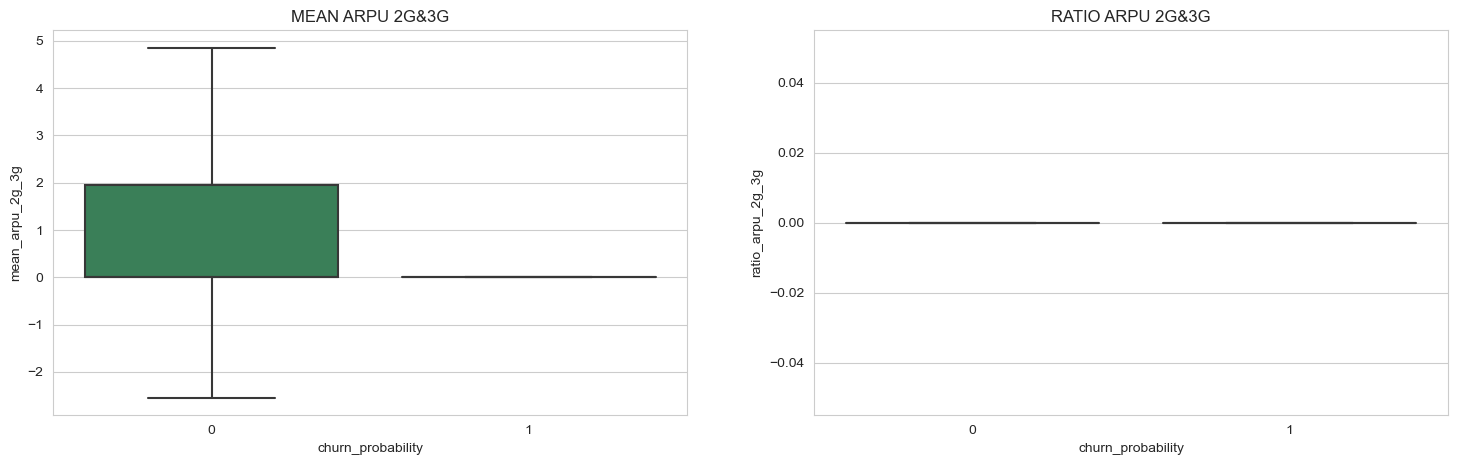

In [244]:
fig, axes = plt.subplots(1, 2, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='mean_arpu_2g_3g', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='ratio_arpu_2g_3g', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])

axes[0].set_title('MEAN ARPU 2G&3G')
axes[1].set_title('RATIO ARPU 2G&3G')

In [245]:
preproc_cols.extend(arpu_2g_3g)
len(preproc_cols)

120

### 25. VBC  <a class="anchor"  id="25"></a>

In [246]:
df.columns[df.columns.str.contains('vbc')]

Index(['aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g'], dtype='object')

In [247]:
vbc_3g = ['aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g']

In [248]:
df[vbc_3g].isnull().mean()

aug_vbc_3g    0.0
jul_vbc_3g    0.0
jun_vbc_3g    0.0
dtype: float64

In [249]:
df.groupby('churn_probability')[vbc_3g].mean()

,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
churn_probability,,,
0,73.827215,69.554308,62.032521
1,17.700251,34.039739,42.836966


In [250]:
df.groupby('churn_probability')[vbc_3g].median()

,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
churn_probability,,,
0,0.0,0.0,0.0
1,0.0,0.0,0.0


In [251]:
df['mean_vbc_3g'] = df[vbc_3g].mean(axis=1)

In [252]:
ratio_column(df, 'ratio_vbc_3g', ['aug_vbc_3g'], ['jul_vbc_3g', 'jun_vbc_3g'], 10000)

Text(0.5, 1.0, 'RATIO VBC 2G&3G')

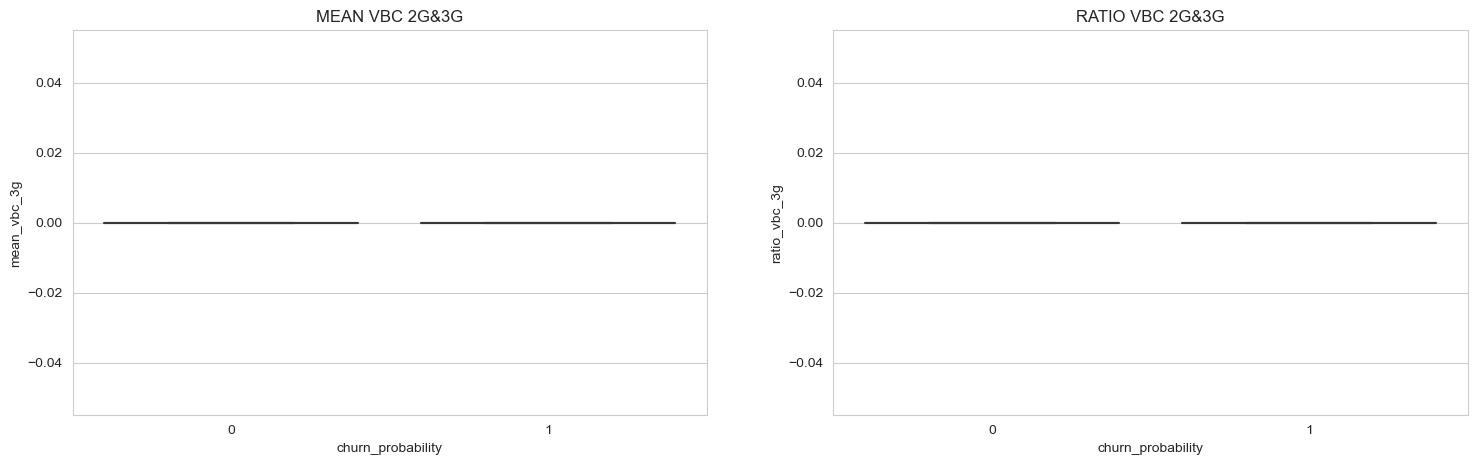

In [253]:
fig, axes = plt.subplots(1, 2, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='mean_vbc_3g', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='ratio_vbc_3g', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])

axes[0].set_title('MEAN VBC 2G&3G')
axes[1].set_title('RATIO VBC 2G&3G')

In [254]:
preproc_cols.extend(vbc_3g)
len(preproc_cols)

123

### 26. MONTHLY 2G&3G <a class="anchor"  id="26"></a>

In [255]:
monthly_2g_3g = ['monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 
                 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8']

In [256]:
df[monthly_2g_3g].isnull().mean()

monthly_2g_6    0.0
monthly_2g_7    0.0
monthly_2g_8    0.0
monthly_3g_6    0.0
monthly_3g_7    0.0
monthly_3g_8    0.0
dtype: float64

In [257]:
df.groupby('churn_probability')[monthly_2g_3g].mean()

,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8
churn_probability,,,,,,
0,0.083207,0.089411,0.088616,0.076749,0.080917,0.088170
1,0.044728,0.030426,0.013180,0.067583,0.049635,0.027201


In [258]:
df.groupby('churn_probability')[monthly_2g_3g].median()

,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8
churn_probability,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0


In [259]:
df['mean_monthly_2g_3g'] = df[monthly_2g_3g].mean(axis=1)

In [260]:
df[monthly_2g_3g].head(2)

,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8
0,0,0,0,0,0,0
1,0,0,0,0,1,0


In [261]:
ratio_column(df, 'ratio_monthly_2g_3g', ['monthly_2g_8', 'monthly_3g_8'], 
             ['monthly_2g_6', 'monthly_2g_7', 'monthly_3g_6', 'monthly_3g_7'], 25)


Text(0.5, 1.0, 'RATIO MONTHLY 2G&3G')

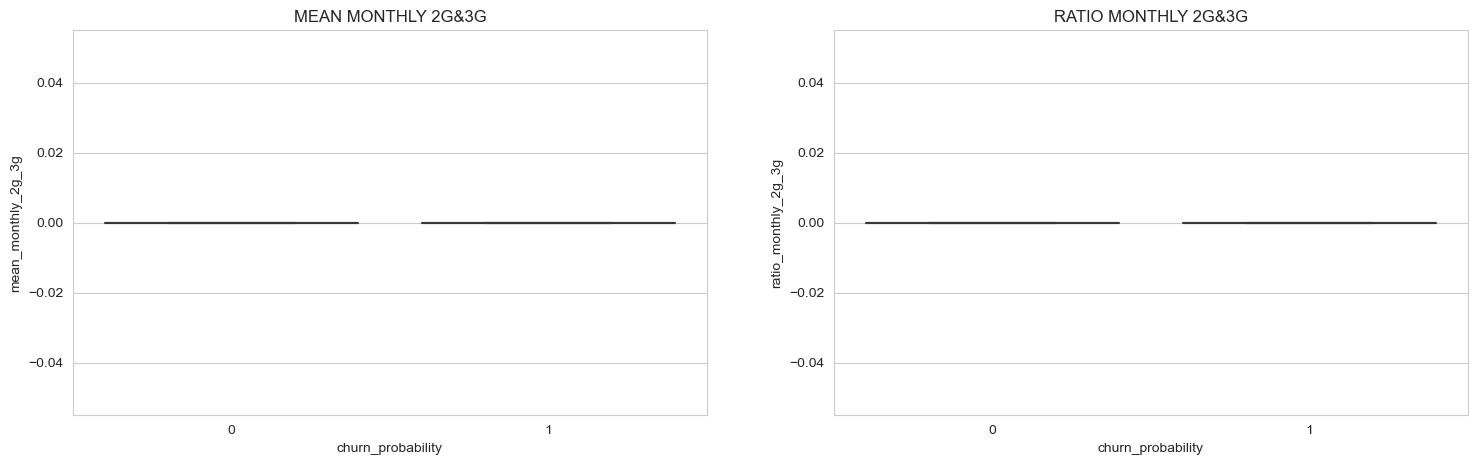

In [262]:
fig, axes = plt.subplots(1, 2, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='mean_monthly_2g_3g', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='ratio_monthly_2g_3g', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])

axes[0].set_title('MEAN MONTHLY 2G&3G')
axes[1].set_title('RATIO MONTHLY 2G&3G')

In [263]:
preproc_cols.extend(monthly_2g_3g)
len(preproc_cols)

129

### 27. MAX RECH <a class="anchor"  id="27"></a>

In [264]:
max_rech = ['max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8']

In [265]:
df[max_rech].isnull().mean()

max_rech_amt_6    0.0
max_rech_amt_7    0.0
max_rech_amt_8    0.0
dtype: float64

In [266]:
df.groupby('churn_probability')[max_rech].mean()

,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8
churn_probability,,,
0,105.182353,107.122194,114.207724
1,99.165031,77.828800,48.768929


In [267]:
df.groupby('churn_probability')[max_rech].median()

,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8
churn_probability,,,
0,110.0,110.0,119.0
1,90.0,50.0,0.0


In [268]:
df['mean_max_rech'] = df[max_rech].mean(axis=1)
df['median_max_rech'] = df[max_rech].median(axis=1)

In [269]:
ratio_column(df, 'ratio_max_rech', ['max_rech_amt_8'], ['max_rech_amt_6', 'max_rech_amt_7'], 140)


Text(0.5, 1.0, 'RATIO MAX RECH')

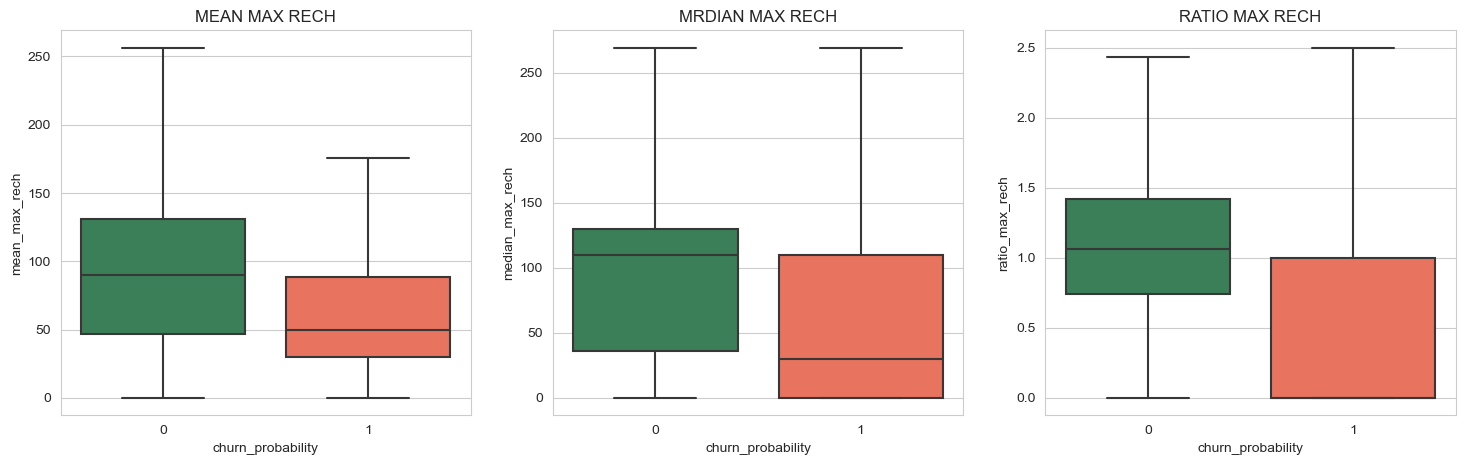

In [270]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.set_style("whitegrid")
sns.boxplot(data=df, x='churn_probability', y='mean_max_rech', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[0])
sns.boxplot(data=df, x='churn_probability', y='median_max_rech', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[1])
sns.boxplot(data=df, x='churn_probability', y='ratio_max_rech', showfliers=False,
            palette={0: 'seagreen', 1:'tomato'}, ax=axes[2])

axes[0].set_title('MEAN MAX RECH')
axes[1].set_title('MRDIAN MAX RECH')
axes[2].set_title('RATIO MAX RECH')

In [271]:
preproc_cols.extend(max_rech)
len(preproc_cols)

132

### 28. SACHET <a class="anchor"  id="28"></a>

In [272]:
sachet_2g_3g = ['sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 
                'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8']

In [273]:
df[sachet_2g_3g].describe()

,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8
count,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000
mean,0.388863,0.441406,0.449492,0.075344,0.081444,0.085487
std,1.494206,1.651012,1.632450,0.573003,0.634547,0.680035
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,42.000000,48.000000,44.000000,29.000000,33.000000,41.000000


Sachet here looks like a num of the customer payment plan, not a number of sachets, so I will mark it as categorical variable. 

### 29. NIGHT PCK <a class="anchor"  id="29"></a>

In [274]:
night_pck = ['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8']

In [275]:
df[night_pck].fillna(0).describe()

,night_pck_user_6,night_pck_user_7,night_pck_user_8
count,69999.000000,69999.000000,69999.000000
mean,0.006343,0.006143,0.005529
std,0.079390,0.078136,0.074150
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000


It's an indicator, so it's a categorical variable.

### 30. AON <a class="anchor"  id="30"></a>

In [276]:
df['aon']

0        1958
1         710
2         882
3         982
4         647
         ... 
69994     221
69995     712
69996     879
69997     277
69998    1876
Name: aon, Length: 69999, dtype: int64

<AxesSubplot:xlabel='aon', ylabel='Count'>

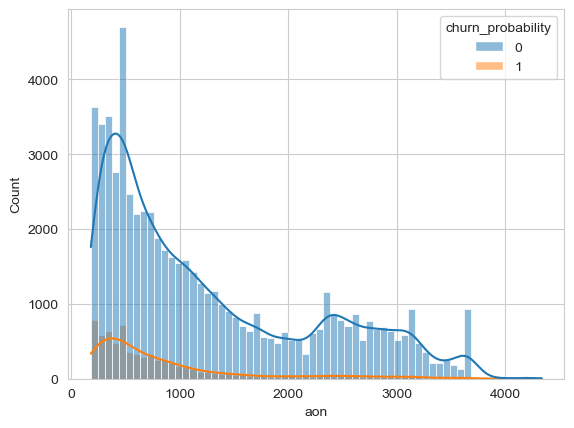

In [277]:
sns.histplot(df, x='aon', hue='churn_probability', kde=True)

In [278]:
preproc_cols.extend(['aon'])
len(preproc_cols)

133

### 31. USELESS FEATURES <a class="anchor"  id="31"></a>

In [279]:
### USELESS FEATURES
drop_cols = ['id', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8']

In [280]:
df.drop(drop_cols, axis=1, inplace=True)

### 32. CAT FEATURES <a class="anchor"  id="32"></a>

In [281]:
cat_features = ['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8',
                'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 
                'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 
                'fb_user_6', 'fb_user_7', 'fb_user_8']

In [282]:
df[cat_features] = df[cat_features].fillna(0)

In [283]:
preproc_cols.extend(cat_features)
len(preproc_cols)

145

## TEST DATA SET PREPROCESSING <a class="anchor"  id="test_data_preproc"></a>

In [284]:
df_test.drop(constant_features, axis=1, inplace=True)

day_counts(df_test, date_of_last_rech, own_date, 'last_rech_days')
day_counts(df_test, date_of_last_rech_data, own_date, 'last_rech_data_days')
df_test[['last_rech_days', 'last_rech_data_days']] = df_test[['last_rech_days', 'last_rech_data_days']].fillna(-1)

df_test[col_roam] = df_test[col_roam].fillna(0)
df_test['mean_roam'] = df_test[col_roam].mean(axis=1)
df_test['ratio_roam'] = df_test[['roam_ic_mou_8', 'roam_og_mou_8']].sum(axis=1) /\
df_test[['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_og_mou_6', 'roam_og_mou_7']].mean(axis=1)
df_test['ratio_roam'] = df_test['ratio_roam'].fillna(0)
df_test['ratio_roam'].replace([np.inf, -np.inf], 10000, inplace=True)
## T2T loc
df_test[loc_t2t] = df_test[loc_t2t].fillna(0)
df_test['mean_loc_t2t'] = df_test[loc_t2t].mean(axis=1)
df_test['median_loc_t2t'] = df_test[loc_t2t].median(axis=1)
ratio_column(df_test, 'ratio_loc_t2t', ['loc_og_t2t_mou_8', 'loc_ic_t2t_mou_8'], 
             ['loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7'], 30000)
## T2T std
df_test[std_t2t] = df_test[std_t2t].fillna(0)
df_test['mean_std_t2t'] = df_test[std_t2t].mean(axis=1)
ratio_column(df_test, 'ratio_std_t2t', ['std_og_t2t_mou_8', 'std_ic_t2t_mou_8'], 
             ['std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7'], 10000)

### T2M LOC
df_test[loc_t2m] = df_test[loc_t2m].fillna(0)
df_test['mean_loc_t2m'] = df_test[loc_t2m].mean(axis=1)
df_test['median_loc_t2m'] = df_test[loc_t2m].median(axis=1)
ratio_column(df_test, 'ratio_loc_t2m', ['std_og_t2t_mou_8', 'std_ic_t2t_mou_8'], 
             ['std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7'], 10000)
### T2M STD
df_test[std_t2m] = df_test[std_t2m].fillna(0)
df_test['mean_std_t2m'] = df_test[std_t2m].mean(axis=1)
df_test['median_std_t2m'] = df_test[std_t2m].median(axis=1)
ratio_column(df_test, 'ratio_std_t2m', ['std_og_t2m_mou_8', 'std_ic_t2m_mou_8'], 
             ['std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7'], 100000)

### T2F LOC
df_test[loc_t2f] = df_test[loc_t2f].fillna(0)
df_test['mean_loc_t2f'] = df_test[loc_t2f].mean(axis=1)
ratio_column(df_test, 'ratio_loc_t2f', ['loc_og_t2f_mou_8', 'loc_ic_t2f_mou_8'], 
             ['loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7'], 8000)

### T2F STD
df_test[std_t2f] = df_test[std_t2f].fillna(0)
df_test['mean_std_t2f'] = df_test[std_t2f].mean(axis=1)
ratio_column(df_test, 'ratio_std_t2f', ['std_og_t2f_mou_8', 'std_ic_t2f_mou_8'], 
             ['std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7'], 5500)

### T2C
df_test[t2c] = df_test[t2c].fillna(0)
df_test['mean_t2c'] = df_test[t2c].mean(axis=1)
ratio_column(df_test, 'ratio_t2c', ['loc_og_t2c_mou_8'], ['loc_og_t2c_mou_6', 'loc_og_t2c_mou_7'], 8500)

### ARPU
df_test['mean_arpu'] = df_test[arpu].mean(axis=1)
df_test['median_arpu'] = df_test[arpu].median(axis=1)
ratio_column(df_test, 'ratio_arpu', ['arpu_8'], ['arpu_7', 'arpu_6'], 133000)

### ONNET
df_test['mean_onnet'] = df_test[onnet].mean(axis=1)
df_test['median_onnet'] = df_test[onnet].median(axis=1)
ratio_column(df_test, 'ratio_onnet', ['onnet_mou_8'], ['onnet_mou_7', 'onnet_mou_6'], 150000)

### OFFNET
df_test['mean_offnet'] = df_test[offnet].mean(axis=1)
df_test['median_offnet'] = df_test[offnet].median(axis=1)
ratio_column(df_test, 'ratio_offnet', ['offnet_mou_8'], ['offnet_mou_6', 'offnet_mou_7'], 200000)

### ISD
df_test[isd] = df_test[isd].fillna(0)
df_test['mean_isd'] = df_test[isd].mean(axis=1)
ratio_column(df_test, 'ratio_isd', ['isd_og_mou_8', 'isd_ic_mou_8'], 
             ['isd_og_mou_6', 'isd_og_mou_7', 'isd_ic_mou_6', 'isd_ic_mou_7'], 30000)

### SPL
df_test[spl] = df_test[spl].fillna(0)
df_test['mean_spl'] = df_test[spl].mean(axis=1)
ratio_column(df_test, 'ratio_spl', ['spl_og_mou_8', 'spl_ic_mou_8'], 
             ['spl_og_mou_6', 'spl_og_mou_7', 'spl_ic_mou_6', 'spl_ic_mou_7'], 20000)

### TOTAL OG\IC
df_test['mean_total_calls'] = df_test[total_calls].mean(axis=1)
df_test['median_total_calls'] = df_test[total_calls].median(axis=1)
ratio_column(df_test, 'ratio_total_calls', ['total_og_mou_8', 'total_ic_mou_8'], 
             ['total_og_mou_6', 'total_og_mou_7', 'total_ic_mou_6', 'total_ic_mou_7'], 100000)

### LOC OG\IC
df_test[loc_og_ic] = df_test[loc_og_ic].fillna(0)
df_test['mean_loc_og_ic'] = df_test[loc_og_ic].mean(axis=1)
df_test['median_loc_og_ic'] = df_test[loc_og_ic].median(axis=1)
ratio_column(df_test, 'ratio_loc_og_ic', ['loc_og_mou_8', 'loc_ic_mou_8'], 
             ['loc_og_mou_6', 'loc_og_mou_7', 'loc_ic_mou_6', 'loc_ic_mou_7'], 15000)

### STD OG\IC
df_test[std_og_ic] = df_test[std_og_ic].fillna(0)
df_test['mean_std_og_ic'] = df_test[std_og_ic].mean(axis=1)
df_test['median_std_og_ic'] = df_test[std_og_ic].median(axis=1)
ratio_column(df_test, 'ratio_std_og_ic', ['std_og_mou_8', 'std_ic_mou_8'], 
             ['std_og_mou_6', 'std_og_mou_7', 'std_ic_mou_6', 'std_ic_mou_7'], 45000)

### OTHERS
df_test[others_og_ic] = df_test[others_og_ic].fillna(0)
df_test['mean_others_og_ic'] = df_test[others_og_ic].mean(axis=1)
ratio_column(df_test, 'ratio_others_og_ic', ['og_others_8', 'ic_others_8'], 
             ['og_others_6', 'og_others_7', 'ic_others_6', 'ic_others_7'], 7300)

### RECH AMT
df_test['mean_reach_amt'] = df_test[reach_amt].mean(axis=1)
df_test['median_reach_amt'] = df_test[reach_amt].median(axis=1)
ratio_column(df_test, 'ratio_reach_amt', ['total_rech_amt_8'], ['total_rech_amt_6', 'total_rech_amt_7'], 200)

### RECH NUM
df_test['mean_reach_num'] = df_test[reach_num].mean(axis=1)
df_test['median_reach_num'] = df_test[reach_num].median(axis=1)
ratio_column(df_test, 'ratio_reach_num', ['total_rech_num_8'], ['total_rech_num_6', 'total_rech_num_7'], 70)

### RECH DATA TOTAL
df_test[reach_data] = df_test[reach_data].fillna(0)
df_test['mean_reach_data'] = df_test[reach_data].mean(axis=1)
ratio_column(df_test, 'ratio_reach_data', ['total_rech_data_8'], ['total_rech_data_6', 'total_rech_data_7'], 50)

### LAST DAY REACH
ratio_column(df_test, 'ratio_reach_last_day', ['last_day_rch_amt_8'], ['last_day_rch_amt_6', 'last_day_rch_amt_7'], 110)

### RECH 2G AND 3G
df_test[rech_2g_3g] = df_test[rech_2g_3g].fillna(0)
df_test['mean_rech_2g_3g'] = df_test[rech_2g_3g].mean(axis=1)
ratio_column(df_test, 'ratio_rech_2g_3g', ['count_rech_2g_8', 'count_rech_3g_8'], 
             ['count_rech_2g_6', 'count_rech_2g_7', 'count_rech_3g_6', 'count_rech_3g_7'], 90)

### VOL 2G&3G
df_test['mean_vol_2g_3g'] = df_test[vol_2g_3g].mean(axis=1)
ratio_column(df_test, 'ratio_vol_2g_3g', ['vol_2g_mb_8', 'vol_3g_mb_8'], 
             ['vol_2g_mb_6', 'vol_2g_mb_7', 'vol_3g_mb_6', 'vol_3g_mb_7'], 480000)

#ARPU 2G&3G
df_test[arpu_2g_3g] = df_test[arpu_2g_3g].fillna(0)
df_test['mean_arpu_2g_3g'] = df_test[arpu_2g_3g].mean(axis=1)
ratio_column(df_test, 'ratio_arpu_2g_3g', ['arpu_3g_8', 'arpu_2g_8'], 
             ['arpu_3g_6', 'arpu_3g_7', 'arpu_2g_6', 'arpu_2g_7'], 355000)

### TOTAL OG\IC
df_test['mean_vbc_3g'] = df_test[vbc_3g].mean(axis=1)
ratio_column(df_test, 'ratio_vbc_3g', ['aug_vbc_3g'], ['jul_vbc_3g', 'jun_vbc_3g'], 10000)

### MONTHLY 2G&3G
df_test['mean_monthly_2g_3g'] = df_test[monthly_2g_3g].mean(axis=1)
ratio_column(df_test, 'ratio_monthly_2g_3g', ['monthly_2g_8', 'monthly_3g_8'], 
             ['monthly_2g_6', 'monthly_2g_7', 'monthly_3g_6', 'monthly_3g_7'], 25)

### MAX RECH
df_test['mean_max_rech'] = df_test[max_rech].mean(axis=1)
df_test['median_max_rech'] = df_test[max_rech].median(axis=1)
ratio_column(df_test, 'ratio_max_rech', ['max_rech_amt_8'], ['max_rech_amt_6', 'max_rech_amt_7'], 140)

### CAT
df_test[cat_features] = df_test[cat_features].fillna(0)

print(df_test.shape)

(30000, 219)


In [285]:
df_test.head(2)

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,last_rech_days,last_rech_data_days,mean_roam,ratio_roam,mean_loc_t2t,median_loc_t2t,ratio_loc_t2t,mean_std_t2t,ratio_std_t2t,mean_loc_t2m,median_loc_t2m,ratio_loc_t2m,mean_std_t2m,median_std_t2m,ratio_std_t2m,mean_loc_t2f,ratio_loc_t2f,mean_std_t2f,ratio_std_t2f,mean_t2c,ratio_t2c,mean_arpu,median_arpu,ratio_arpu,mean_onnet,median_onnet,ratio_onnet,mean_offnet,median_offnet,ratio_offnet,mean_isd,ratio_isd,mean_spl,ratio_spl,mean_total_calls,median_total_calls,ratio_total_calls,mean_loc_og_ic,median_loc_og_ic,ratio_loc_og_ic,mean_std_og_ic,median_std_og_ic,ratio_std_og_ic,mean_others_og_ic,ratio_others_og_ic,mean_reach_amt,median_reach_amt,ratio_reach_amt,mean_reach_num,median_reach_num,ratio_reach_num,mean_reach_data,ratio_reach_data,ratio_reach_last_day,mean_rech_2g_3g,ratio_rech_2g_3g,mean_vol_2g_3g,ratio_vol_2g_3g,mean_arpu_2g_3g,ratio_arpu_2g_3g,mean_vbc_3g,ratio_vbc_3g,mean_monthly_2g_3g,ratio_monthly_2g_3g,mean_max_rech,median_max_rech,ratio_max_rech
0,69999,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,0.0,0.0,0.0,0.0,0.0,0.0,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.0,0.0,0.0,0.03,43.01,44.71,29.43,6.9,0.0,2.05,42.03,7.68,26.43,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.0,91.94,52.39,57.94,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.0,0.0,40.81,42.16,31.51,0.0,0.0,0.0,0.36,1.04,4.34,0.0,0.0,0.0,0.36,1.04,4.34,41.73,43.56,36.26,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.0,5,5,4,103,90,60,50,30,30,30,30,0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1692,0.0,0.0,0.0,17.0,-1.0,0.0,0.0,26.006667,23.43,1.523540,1.491667,1.188406,10.285000,9.870,1.188406,13.646667,6.010,2.408139,2.306667,0.0,0.0,0.0,0.01,8500.0,73.885667,65.330,0.819848,25.04,23.1

## FEATURE SELECTION <a class="anchor"  id="FS"></a>

I've already fit a model with all features and it gave me an accuracy: 0.9456. Now I want to fit a model on a smaller data set and check the accuracy. I'll delete highly correlated features and exclude categorical features because they had a very small feature importance in the previous model.

In [286]:
df_clean = df.loc[:, ~df.columns.isin(preproc_cols)]

In [287]:
corr_pairs = {}
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns    
    corr_matrix = dataset.corr()    
    for i in range(len(corr_matrix.columns)): 
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[j]  # getting the name of column
                if colname not in ([f[0] for f in corr_pairs.values()]):        
                    corr_pairs[corr_matrix.columns[i]] = colname
                    #corr_pairs[corr_matrix.columns[i]].append(colname)
                    col_corr.add(colname)
    return corr_pairs

In [288]:
corr_features = correlation(df_clean, 0.8)
print('correlated features: ', len(set(corr_features)) )

correlated features:  23


In [289]:
corr_features

{'median_loc_t2t': 'mean_loc_t2t',
 'median_loc_t2m': 'mean_loc_t2m',
 'median_std_t2m': 'mean_std_t2m',
 'median_arpu': 'mean_arpu',
 'mean_onnet': 'mean_std_t2t',
 'median_onnet': 'mean_onnet',
 'mean_offnet': 'mean_std_t2m',
 'median_offnet': 'mean_offnet',
 'median_total_calls': 'mean_total_calls',
 'ratio_total_calls': 'ratio_loc_t2m',
 'mean_loc_og_ic': 'median_loc_t2m',
 'median_loc_og_ic': 'mean_loc_og_ic',
 'ratio_loc_og_ic': 'ratio_total_calls',
 'median_std_og_ic': 'mean_std_og_ic',
 'mean_reach_amt': 'median_arpu',
 'median_reach_amt': 'mean_reach_amt',
 'median_reach_num': 'mean_reach_num',
 'mean_rech_2g_3g': 'mean_reach_data',
 'ratio_rech_2g_3g': 'ratio_reach_data',
 'ratio_vol_2g_3g': 'ratio_rech_2g_3g',
 'ratio_arpu_2g_3g': 'ratio_vol_2g_3g',
 'median_max_rech': 'mean_max_rech',
 'ratio_max_rech': 'ratio_reach_amt'}

In [290]:
df_clean.drop([f for f in corr_features.values()], axis=1, inplace=True)

In [291]:
df_clean.shape

(69999, 46)

## CATBOOST + OPTUNA <a class="anchor"  id="catboost_optuna"></a>

In [292]:
# I exclude cat features now
#cat_features = ['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8',
#                'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 
#                'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 
#                'fb_user_6', 'fb_user_7', 'fb_user_8']
#
#df_clean[cat_features] = df[cat_features]
#df_clean[cat_features] = df_clean[cat_features].astype(int)

In [293]:
df_clean.drop('churn_probability', axis=1, inplace=True)

In [294]:
train_pool_data = Pool(data = df_clean,
                       label = df.churn_probability,
                  #     cat_features=cat_features
                    )

In [295]:
def objective(trial):
    global train_pool_data
    
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.07, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 6000, step=1),
        'max_depth': trial.suggest_int('max_depth', 6, 10, step=1),
        'subsample': trial.suggest_float('subsample', 0.4, 1),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 0.99),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.01, 15.0),
        "eval_metric": trial.suggest_categorical('eval_metric', ["AUC"]),
        "loss_function": trial.suggest_categorical('loss_function', ['Logloss']),
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced']),
    }
    
    cbr = CatBoostClassifier(**param)
    
    scores = cv(train_pool_data, param, fold_count=2)

    return scores['test-AUC-mean'].values[-1]

In [296]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=2, timeout=10)

[I 2022-11-07 11:58:21,507] A new study created in memory with name: no-name-00d7555d-37ba-4643-9e48-68bca1bf0cf3


Training on fold [0/2]

0:	test: 0.9033820	best: 0.9033820 (0)	total: 174ms	remaining: 2m 55s

1:	test: 0.9135811	best: 0.9135811 (1)	total: 196ms	remaining: 1m 38s

2:	test: 0.9261249	best: 0.9261249 (2)	total: 222ms	remaining: 1m 14s

3:	test: 0.9270276	best: 0.9270276 (3)	total: 240ms	remaining: 1m

4:	test: 0.9286603	best: 0.9286603 (4)	total: 280ms	remaining: 56.3s

5:	test: 0.9305704	best: 0.9305704 (5)	total: 303ms	remaining: 50.8s

6:	test: 0.9306060	best: 0.9306060 (6)	total: 341ms	remaining: 49s

7:	test: 0.9337302	best: 0.9337302 (7)	total: 364ms	remaining: 45.7s

8:	test: 0.9348589	best: 0.9348589 (8)	total: 400ms	remaining: 44.6s

9:	test: 0.9349465	best: 0.9349465 (9)	total: 428ms	remaining: 42.9s

10:	test: 0.9360091	best: 0.9360091 (10)	total: 456ms	remaining: 41.5s

11:	test: 0.9364601	best: 0.9364601 (11)	total: 477ms	remaining: 39.7s

12:	test: 0.9367892	best: 0.9367892 (12)	total: 508ms	remaining: 39s

13:	test: 0.9373350	best: 0.9373350 (13)	total: 528ms	remaining:

[I 2022-11-07 11:59:13,677] Trial 0 finished with value: 0.945050421723294 and parameters: {'learning_rate': 0.07913788496165296, 'n_estimators': 1012, 'max_depth': 7, 'subsample': 0.6889166098266926, 'colsample_bylevel': 0.9133235217680133, 'l2_leaf_reg': 11.137660147819362, 'eval_metric': 'AUC', 'loss_function': 'Logloss', 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.945050421723294.


1011:	test: 0.9446353	best: 0.9476509 (188)	total: 25.9s	remaining: 0us



bestTest = 0.9476509152

bestIteration = 188




In [ ]:
### BEST PARAMS FOR ALL DATA MODEL
#parameters = {'learning_rate': 0.0963346858872295, 
#              'n_estimators': 5259, 
#              'max_depth': 8, 
#              'subsample': 0.9298672804760373, 
#              'colsample_bylevel': 0.91038836968521, 
#              'l2_leaf_reg': 4.772618910871072, 
#              'eval_metric': 'AUC', 
#              'loss_function': 'Logloss', 
#              'auto_class_weights': 'Balanced'}

In [297]:
### BEST PARAMS FOR DATA SET WITHOUT CORR FEATURES
parameters = {'learning_rate': 0.07388916457724126,
              'n_estimators': 2974,
              'max_depth': 10,
              'subsample': 0.9929370979937032,
              'colsample_bylevel': 0.6232447785973279,
              'l2_leaf_reg': 10.609181901360438,
              'eval_metric': 'AUC',
              'loss_function': 'Logloss',
              'auto_class_weights': 'Balanced'
             }

In [ ]:
#parameters = study.best_trial.params

In [302]:
cbc = CatBoostClassifier(**parameters)
cbc.fit(train_pool_data)

0:	total: 100ms	remaining: 4m 57s

1:	total: 201ms	remaining: 4m 58s

2:	total: 294ms	remaining: 4m 51s

3:	total: 397ms	remaining: 4m 54s

4:	total: 488ms	remaining: 4m 49s

5:	total: 595ms	remaining: 4m 54s

6:	total: 685ms	remaining: 4m 50s

7:	total: 783ms	remaining: 4m 50s

8:	total: 885ms	remaining: 4m 51s

9:	total: 1s	remaining: 4m 58s

10:	total: 1.1s	remaining: 4m 56s

11:	total: 1.19s	remaining: 4m 54s

12:	total: 1.29s	remaining: 4m 53s

13:	total: 1.39s	remaining: 4m 54s

14:	total: 1.49s	remaining: 4m 54s

15:	total: 1.6s	remaining: 4m 56s

16:	total: 1.71s	remaining: 4m 57s

17:	total: 1.81s	remaining: 4m 56s

18:	total: 1.91s	remaining: 4m 56s

19:	total: 2.02s	remaining: 4m 57s

20:	total: 2.11s	remaining: 4m 56s

21:	total: 2.2s	remaining: 4m 55s

22:	total: 2.29s	remaining: 4m 54s

23:	total: 2.39s	remaining: 4m 53s

24:	total: 2.48s	remaining: 4m 52s

25:	total: 2.57s	remaining: 4m 51s

26:	total: 2.66s	remaining: 4m 50s

27:	total: 2.77s	remaining: 4m 51s

28:	tota

In [ ]:
#cbc.save_model('catboost_selected')

In [303]:
#cbc_load = CatBoostClassifier()
#cbc_load.load_model('catboost_selected')

In [304]:
data = list(zip(cbc.feature_names_, cbc.feature_importances_))
df_features_importance = pd.DataFrame(data, columns =['Feature', 'Importance'])

In [305]:
df_features_importance.sort_values('Importance', ascending=False)

,Feature,Importance
0,last_rech_days,7.491781
26,ratio_loc_og_ic,5.780041
34,ratio_reach_last_day,4.967936
3,ratio_roam,4.161612
9,mean_loc_t2f,3.695253
...,...,...
39,mean_vbc_3g,0.510678
40,ratio_vbc_3g,0.493860
38,ratio_arpu_2g_3g,0.471222
21,ratio_isd,0.459100


## Optimal threshold searching <a class="anchor"  id="treshold"></a>

It's imbalanced data set and usually for classification are used F1-score or balanced-accuracy. It's possible to move a threshold to improve model performance. More about it you can find here - [Optimal threshold searching.](https://www.kaggle.com/code/nastyadots/optimal-threshold-searching)

In [312]:
#functions for searching best threshold

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

def best_tresholds_f1(y_pred_proba, y_test):
    # define thresholds
    thresholds = np.arange(0, 1, 0.001)
    # evaluate each threshold
    scores = [f1_score(y_test, to_labels(y_pred_proba, t)) for t in thresholds]
    # get best threshold
    ix = np.argmax(scores)
    #print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))
    return thresholds[ix], scores[ix]

In [326]:
def confusion_matrix_visualization(cf_matrix):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = [f'{value:.0f}' for value in cf_matrix.flatten()]
    group_percentages = [f'{value:.2%}' for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    fig, ax = plt.subplots(figsize=(6,4))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [307]:
y_proba = cbc.predict_proba(df_clean)[:,1]

In [308]:
treshold_f1 = best_tresholds_f1(y_proba, df.churn_probability)
print(f'F1 score: {treshold_f1[1]:.4f}, treshold: {treshold_f1[0]}')

F1 score: 0.9946, treshold: 0.899


		CONFUSION MATRIX, TRESHOLD = 0.5

F1-score: 0.9716

Acc-score: 0.9940


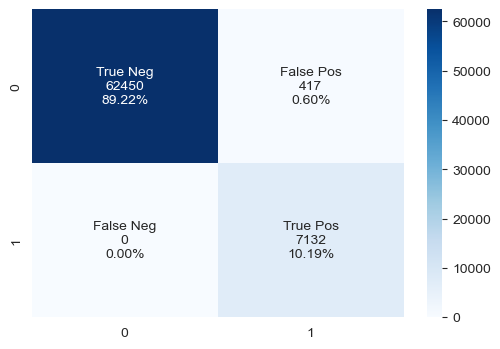

In [336]:
print('\t\tCONFUSION MATRIX, TRESHOLD = 0.5')
confusion_matrix_visualization(confusion_matrix(df.churn_probability, to_labels(y_proba,0.5)))
print(f'F1-score: {f1_score(df.churn_probability, to_labels(y_proba,0.5)):.4f}')
print(f'Acc-score: {accuracy_score(df.churn_probability, to_labels(y_proba,0.5)):.4f}')

		CONFUSION MATRIX, TRESHOLD = 0.899

F1-score: 0.9946

Acc-score: 0.9989


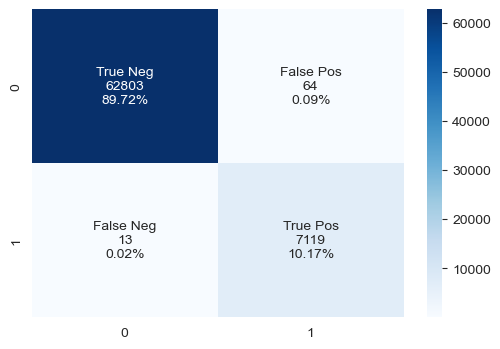

In [335]:
print('\t\tCONFUSION MATRIX, TRESHOLD = 0.899')
confusion_matrix_visualization(confusion_matrix(df.churn_probability, to_labels(y_proba,0.899)))
print(f'F1-score: {f1_score(df.churn_probability, to_labels(y_proba,0.899)):.4f}')
print(f'Acc-score: {accuracy_score(df.churn_probability, to_labels(y_proba,0.899)):.4f}')

In [313]:
df_test_1 = df_test[df_clean.columns].fillna(0)
#df_test_1[cat_features] = df_test_1[cat_features].astype(int)

### PREDICTION
y_test_own = cbc.predict_proba(df_test_1)[:,1]

In [314]:
df_my_solution = df_test[['id']]
df_my_solution['churn_probability'] = to_labels(y_test_own,0.899)
df_my_solution.to_csv('my_solution_selected_f_899.csv', index=False)
### Acc: 0.9411

In [316]:
df_my_solution = df_test[['id']]
df_my_solution['churn_probability'] = to_labels(y_test_own,0.5)
df_my_solution.to_csv('my_solution_selected_f_5.csv', index=False)
### Acc: 0.94313

Note: I want to highlight that a better F1 score doesn't mean better Accuracy.

## SHAP Values <a class="anchor"  id="shap"></a>

I've used SHAP library to explain how each feature affects the model.  
Official documentation - https://shap.readthedocs.io/en/latest/index.html  
Also a good article how to interpret SHAP - https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137

In [318]:
explainer = shap.TreeExplainer(cbc)
shap_values = explainer.shap_values(df_clean)

The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance.

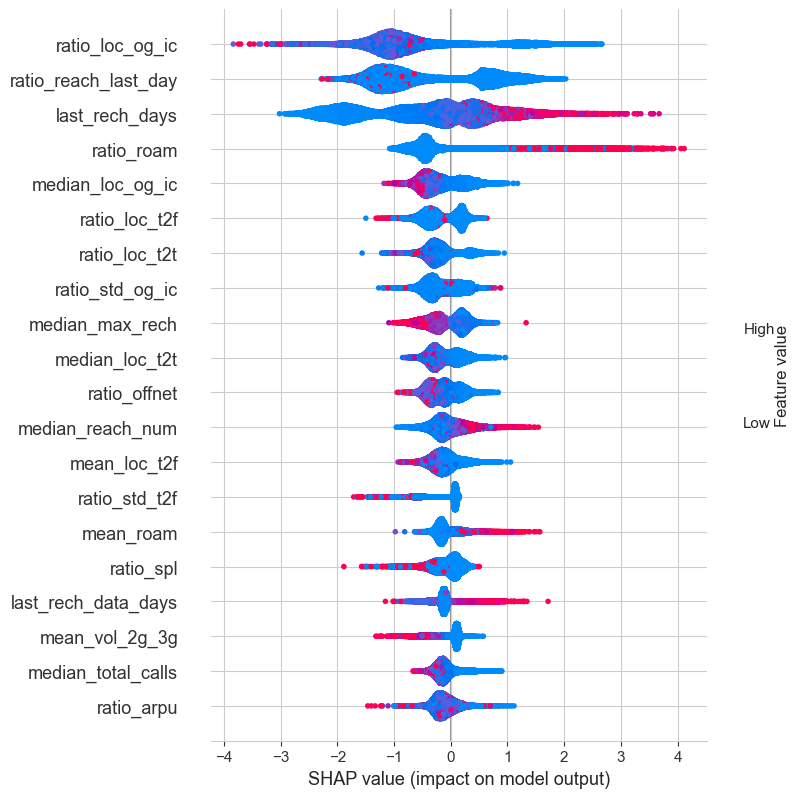

In [319]:
# summarize the effects of all the features
shap.summary_plot(shap_values, df_clean)

## INSIGHTS <a class="anchor"  id="insights"></a> 

I can assume what customers are more likely to churn:
- Customers who have more roaming calls and use more data in roaming.
- Customers who have more outgoing calls outside the calling circle or\and fewer within the same circle.
- Customers who use less internet (especially 3G). 
- Customers who prefer to recharge their accounts more often for smaller amounts.
- Customers who have more "special calls" during the last 2 months. 
- It's interesting that the mean value for recharge AMT in the 6th month is higher for the churn customers. It could be because of overpaying for calls outside the calling circle or other extra charges. So, there is a group in the churn of active customers with high ARPU. They should be kept first of all.